In [1]:
# Compare the nudging runs

import cccmautils as cutl
import constants as con
import pandas as pd
import numpy.ma as ma
import scipy.io as sio
import matplotlib.lines as mlines
%matplotlib inline


# March 15, 2016: remove the map figures.
#                 move to rlx_maps_compare notebook



printtofile=False
calctype='vertint' # 'vertint' or 'vertavg', for calc'ing PHT in script


timeseries = True # load timeseries data. Else climo
seltime = (0,100) #(40,80) #(0,100)
seltime1 = (0,40)
seltime2 = (40,80)
plottimeseries = True # keep the time dim (reread the data)

domonth=False # otherwise do season
sea='ANN'
mo=1



matdir = '/HOME/rkm/pyscripts/pymatfiles/'
basedir='/HOME/rkm/work/DATA/CanESM2/'
fldsuff=''

timeper1='3022-3121'; timeper2='2552-2651'; 
timesel1='3022-01-01,3121-12-31'; timesel2='2552-01-01,2651-12-31'; 

timepertmp='2921-3021'; timepertmp2='2572-2671'
timeseltmp='2922-01-01,3021-12-31'; timeseltmp2='2572-01-01,2671-12-31'

casenames = ('preipreiice', 'prei2xco2iceb','pi2xco2ipulse', '2xco22xco2ice','2xco2preiice')

# 2xco2preiice 2532-2631 # not done....

# 2xco22xco2ice 2552-2651
# preipreiice 3022-3121
# prei2xco2iceb 3022-3121

# pi2xco2ipulse 2921-3021 # not extended...


timepers = {'preipreiice': timeper1, 'prei2xco2iceb': timeper1, 
            'pi2xco2ipulse': timepertmp, '2xco22xco2ice': timeper2,
            '2xco2preiice': timepertmp2} # for file names
timesels = {'preipreiice': timesel1, 'prei2xco2iceb': timesel1, 
            'pi2xco2ipulse': timeseltmp, '2xco22xco2ice': timesel2,
            '2xco2preiice': timeseltmp2} # for .nc selection
colors = {'preipreiice': 'k', 'prei2xco2iceb': 'b', 
            'pi2xco2ipulse': 'cyan', '2xco22xco2ice': 'r',
            '2xco2preiice': 'pink'}


if domonth:
    seasonalizedt={'mo':mo}
else:
    seasonalizedt={'season':sea}


phtkeys=('MPEF','MSHF','MLHF','MFZM')
fluxkeys = ('nettoa','netsfc') # want all the sub fluxes??


#basepath=basedir+casename+'/ts/'
#ncfield='MLT'

if timeseries:
    ttype='timeseries'
    addsig=True
    sigstr='sig'
else:
    ttype='climo'
    addsig=False

# ===== set up constants and conversions =====

Cp=1004 # specific heat at const pressure (J/K/kg)
Lv=2.5e6 # specific heat of condensation (latent heat of vapo) at 0C(?@@) (J/kg)
erad = con.get_earthrad() # m
grav = con.get_g() # m/s2

# 1 cal = 4.186J
# convert to cal / day
# J/s -> cal/day
W2calperday = (60*60*24)/4.186


# ===== get coordinate and util data =====
lat = con.get_t63lat()
lon = con.get_t63lon()
#lev = con.get_t63lev() # 37 levs
# temp file to get level
fname=basedir + 'preipreiice/ts/preipreiice_u_2921-3021_ts.nc' # 22 levs
lev = cnc.getNCvar(fname,'plev')
dp = np.diff(lev)
nlon = len(lon)-1 # removing extra lon for zonal calcs


cellareas=con.get_t63cellareas()
latcircles=cellareas.sum(axis=1)



# LOAD THE DATA FROM .mat
allpht={}; allflux={}
if timeseries: allfluxtm={}
for casename in casenames:
    timeper = timepers[casename]
    
    phtdt={}; fluxdt={}
    if timeseries: fluxtmdt={}
    for fkey in phtkeys:
        matname = matdir + 'PHT/' + fkey + 'fromnc_zonint_'+ calctype +'_' + casename + '_' + \
                  sea + '_' + ttype + timeper +'.mat'
        print 'load ' + matname
        phtdt[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]
        
    for fkey in fluxkeys:
        matname = matdir + 'PHT/' + fkey + '_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.mat'
        print 'load ' + matname
        #tmp = sio.loadmat(matname, squeeze_me=True)
        #print tmp
        print casename,fkey
        tmp = sio.loadmat(matname, squeeze_me=True)[fkey]
        print tmp.shape
        if timeseries:
            fluxtmdt[fkey] = tmp # keep time dim
            tmp = tmp[seltime[0]:seltime[1]].mean(axis=0)
            
        fluxdt[fkey] = tmp

    allpht[casename] = phtdt
    allflux[casename] = fluxdt
    if timeseries: allfluxtm[casename] = fluxtmdt
    
totpht={}
if timeseries: totphttm={}
for casename in casenames:
    
    pht = ma.array(allpht[casename].values())
    print pht.shape
    if timeseries:
        tmp = pht.sum(axis=0)
        totphttm[casename] = tmp # keep time dim
        totpht[casename] = tmp[seltime[0]:seltime[1],...].mean(axis=0)
    else:
        totpht[casename] = pht.sum(axis=0)


# load desired data from .nc (e.g. temperature)
#field='st'; ncfield='ST'
#fnames = {'preipreiice': basedir +'preipreiice/' + 'preipreiice' + '_' + field + '_' + timeper1 + '_ts.nc',
#          'prei2xco2iceb': basepath + 'prei2xco2iceb' + '_' + field + '_' + timeper1 + '_ts.nc', 
#          'pi2xco2ipulse': basepath + 'pi2xco2iceb' + '_' + field + '_' + timeper1 + '_ts.nc',
#          '2xco22xco2ice': basepath + '2xco22xco2ice' + '_' + field + '_' + timeper2 + '_ts.nc',
#          '2xco2preiice': basepath + '2xco2preiice' + '_' + field + '_' + timepertmp + '_ts.nc'}


    

lat: squeezing data upon read all
lon: squeezing data upon read all
plev: squeezing data upon read all
load /HOME/rkm/pyscripts/pymatfiles/PHT/MPEFfromnc_zonint_vertint_preipreiice_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MSHFfromnc_zonint_vertint_preipreiice_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MLHFfromnc_zonint_vertint_preipreiice_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MFZMfromnc_zonint_vertint_preipreiice_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/nettoa_preipreiice_ANN_timeseries3022-3121.mat
preipreiice nettoa
(100, 64)
load /HOME/rkm/pyscripts/pymatfiles/PHT/netsfc_preipreiice_ANN_timeseries3022-3121.mat
preipreiice netsfc
(100, 64)
load /HOME/rkm/pyscripts/pymatfiles/PHT/MPEFfromnc_zonint_vertint_prei2xco2iceb_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MSHFfromnc_zonint_vertint_prei2xco2iceb_ANN_timeseries3022-3121.mat
load /HOME/rkm/pyscripts/

In [2]:
# NC Field Funcs

def load_ncfield(field, ncfield, zonal=True,conv=1):
    """ zonal can also be a region, defined in regiondict in constants.py
        returns dictionaries: full field, time mean, zonal mean
    """
    
    ncflddt={}; ncfldtmdt={}; ncfldzmdt={}
    for casename in casenames:

        fname= basedir + casename +'/ts/' + casename + '_' + field + '_' + timepers[casename] + '_ts.nc'
        timesel=timesels[casename]

        fld=cnc.getNCvar(fname,ncfield,timesel=timesel)*conv # remlon not operational??? why commented out??
        print fname + ', fld.shape ' + str(fld.shape) # @@@


        if timeseries: # do not time average (actually save time average anyway)
            fld = cutl.seasonalize(fld,**seasonalizedt)
            fldtm = fld
            # zonal average
            if zonal==True:
                fldtmzm = fldtm[...,:-1].mean(axis=2) # remove extra lon
            elif zonal in con.get_regiondict().keys():
                
                tempo, _ = cutl.mask_region(fldtm,lat,lon,region=zonal)
                fldtmzm = tempo.mean(axis=2)                
            else:
                fldtmzm = fldtm 
            fldtm = fldtmzm.mean(axis=0)
        else:
            # seasonal & time mean
            fldtm = np.mean(cutl.seasonalize(fld,**seasonalizedt),axis=0) 
            # zonal average
            if zonal:
                fldtmzm = fldtm[...,:-1].mean(axis=1)
            elif zonal in con.get_regiondict().keys():                
                tempo, _ = cutl.mask_region(fldtm,lat,lon,region=zonal)
                fldtmzm = tempo.mean(axis=1)        
            else:
                fldtmzm = fldtm

        print 'fldtm.shape, fldtmzm.shape ' + str(fldtm.shape),str(fldtmzm.shape)
        ncflddt[casename] = fld # keep all dims
        ncfldtmdt[casename] = fldtm # time mean
        ncfldzmdt[casename] = fldtmzm # zonal mean (either w/ or w/o time dim)

    return ncflddt, ncfldtmdt, ncfldzmdt


In [3]:
print timeseries    

deni=913.

nctmpdt, nctmptmdt, nctmpzmdt = load_ncfield('st','ST')
ncsudt, ncsutmdt, ncsuzmdt = load_ncfield('su','SU')
#ncslpdt, ncslptmdt, ncslpzmdt = load_ncfield('pmsl','PMSL')
ncsicdt, ncsictmdt, ncsiczmdt = load_ncfield('sicn','SICN',conv=100)
#ncsitdt, ncsittmdt, ncsitzmdt = load_ncfield('sic','SIC',conv=1/deni)
#ncpcpdt, ncpcpmdt, ncpcpzmdt = load_ncfield('pcp','PCP',conv=86400) # total precip rate. conv from kg/m2/sec to mm/day


#nctZMdt, nctZMtmdt, _ = load_ncfield('tZM','TEMP', zonal=False)
#ncuZMdt, ncuZMtmdt, _ = load_ncfield('uZM','U', zonal=False)
#ncqZMdt, ncqZMtmdt, _ = load_ncfield('qZM','SHUM', zonal=False)
#nczZMdt, nczZMtmdt, _ = load_ncfield('gzZM','PHI', zonal=False,conv=1/con.get_g())


True
/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/pi2xco2ipulse/ts/pi2xco2ipulse_st_2921-3021_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco22xco2ice/ts/2xco22xco2ice_st_2552-2651_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_st_2572-2671_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_su_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_su_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape,

In [4]:
nctmp850dt,nctmp850tmdt,nctmp850zmdt = load_ncfield('t85000','TEMP')

con=reload(con)
# north atlantic avg:
ncsunadt, ncsunatmdt, ncsunazmdt = load_ncfield('su','SU',zonal='nthatlthnnh')
# north pacific avg:
ncsupadt, ncsupatmdt, ncsupazmdt = load_ncfield('su','SU',zonal='nthpacnh')



/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_t85000_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_t85000_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/pi2xco2ipulse/ts/pi2xco2ipulse_t85000_2921-3021_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco22xco2ice/ts/2xco22xco2ice_t85000_2552-2651_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_t85000_2572-2671_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_su_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_su_3022-3121_ts.nc, fld.shape (1200, 64, 12

In [5]:
print timeseries
print nctmpdt['preipreiice'].shape
print nctmptmdt['preipreiice'].shape
print nctmpzmdt['preipreiice'].shape

print nctmpdt['prei2xco2iceb'].shape
print nctmpdt['2xco22xco2ice'].shape
print nctmpdt['2xco2preiice'].shape


True
(100, 64, 129)
(64,)
(100, 64)
(100, 64, 129)
(100, 64, 129)
(100, 64, 129)


In [6]:
# POLEWARD HEAT TRANSPORT FUNCS

# ########### modified from Brian Rose's notes:
# http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture13%20--%20Heat%20transport.html#section5 
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate

    lat_rad = np.deg2rad( lat )
    return ( 1E-15 * 2 * np.math.pi * erad**2 * 
            integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )


# utility func:
def calc_indir_allpht(nettoa,netsfc):
    """ returns total pht, ocn pht, atmos pht
    """

    if nettoa.ndim >1:
        # time is included
        totpht = np.cumsum(nettoa*latcircles,axis=1)
        ocnpht = np.cumsum(netsfc*latcircles,axis=1)
        atmpht = totpht - ocnpht
    else:
        totpht = np.cumsum(nettoa*latcircles)
        ocnpht = np.cumsum(netsfc*latcircles)
        atmpht = totpht - ocnpht
            
    return totpht,ocnpht,atmpht


# utility func:
def calc_indir_pht(nettoa,netsfc):
    
    if nettoa.ndim >1:
        # time is included
        retpht = np.cumsum(nettoa*latcircles,axis=1) -\
              np.cumsum(netsfc*latcircles,axis=1)
    else:
        retpht = np.cumsum(nettoa*latcircles) -\
              np.cumsum(netsfc*latcircles)
            
    return retpht


# plotting funcs
def plot_dirpht_climo(ax,latlim=(-90,90), dylim=None):

    for casename in casenames:
    
        clr = colors[casename]
        ax.plot(lat,totpht[casename], color=clr,linewidth=2)
    
    ax.legend(casenames,loc='best',frameon=False)
    ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    ax.set_ylabel('PHT (W)')

def plot_dirpht_diff(ax,latlim=(-90,90), dylim=None, pct=False):
    
    caselg=[]

    # diff of two controls
    if pct:
        plotfld = (totpht['2xco22xco2ice']-totpht['preipreiice']) / totpht['preipreiice']*100
    else:
        plotfld = totpht['2xco22xco2ice']-totpht['preipreiice']
    ax.plot(lat,plotfld, color='k',linewidth=2)
    caselg.append('2xfull - pi')
    
    # pi climate
    for cii,casename in enumerate(casenames[1:3]):
        print casename
        caselg.append(casename+'-pi')
        clr = colors[casename]
        if pct:
            plotfld = (totpht[casename]-totpht['preipreiice']) / totpht['preipreiice']*100
        else:
            plotfld = totpht[casename]-totpht['preipreiice']
        ax.plot(lat,plotfld, color=clr,linewidth=2)
    # 2xco2 climate
    for cii,casename in enumerate(casenames[4:]):
        print casename
        caselg.append('2xfull-'+casename)
        clr = colors[casename]
        if pct:
            plotfld = (-totpht[casename]+totpht['2xco22xco2ice']) / totpht['2xco22xco2ice']*100
        else:
            plotfld = -totpht[casename]+totpht['2xco22xco2ice']
        ax.plot(lat,plotfld, color=clr,linewidth=2)

    ax.legend(caselg,loc='best',frameon=False)
    ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if pct:
        ax.set_ylabel('Change in PHT (%)')
    else:
        ax.set_ylabel('Change in PHT (W)')
    if dylim != None:
        ax.set_ylim(dylim)

def plot_dirpht_all(latlim=(-90,90), dylim=None, pct=False):
    """ dylim is ylims for the difference subplot
    
    """
    
    fig,axs = plt.subplots(1,2, figsize=(13,5))
    ax=axs[0]
    plot_dirpht_climo(ax,latlim=latlim,dylim=dylim)

    ax=axs[1]
    plot_dirpht_diff(ax,latlim=latlim,dylim=dylim,pct=pct)
    
    return fig

# INDIRECT CALC USING FLUXES =================================       
def plot_indirpht_climo(ax,latlim=(-90,90), dylim=None, linestyle='solid',linewidth=2):
    
    for casename in casenames:
        toa = allflux[casename]['nettoa']
        sfc = allflux[casename]['netsfc']
        pht = calc_indir_pht(toa,sfc) #np.cumsum(toa*latcircles)-np.cumsum(sfc*latcircles)
        
        clr = colors[casename]
        ax.plot(lat,pht, color=clr,linewidth=linewidth,linestyle=linestyle)
    
    ax.legend(casenames,loc='best',frameon=False)
    ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    ax.set_ylabel('PHT (W)')
    

def plot_indirpht_diff(ax,latlim=(-90,90), dylim=None, pct=False,
                       linestyle='solid',linewidth=2):
    
    caselg=[]

    # diff of two controls
    copht = calc_indir_pht(allflux['2xco22xco2ice']['nettoa'],allflux['2xco22xco2ice']['netsfc'])
    pipht = calc_indir_pht(allflux['preipreiice']['nettoa'],allflux['preipreiice']['netsfc'])    
    if pct:
        plotfld = (copht-pipht) / pipht*100
    else:
        plotfld = copht-pipht
        
    ax.plot(lat,plotfld, color='k',linewidth=linewidth,linestyle=linestyle)
    caselg.append('2xfull - pi')
    
    # pi climate
    for cii,casename in enumerate(casenames[1:3]):
        print casename
        caselg.append(casename+'-pi')
        clr = colors[casename]
        thispht = calc_indir_pht(allflux[casename]['nettoa'],allflux[casename]['netsfc'])
        if pct:
            plotfld = (thispht-pipht) / pipht*100
        else:
            plotfld = thispht-pipht
        ax.plot(lat,plotfld, color=clr,linewidth=linewidth,linestyle=linestyle)
    # 2xco2 climate
    for cii,casename in enumerate(casenames[4:]):
        print casename
        caselg.append('2xfull-'+casename)
        clr = colors[casename]
        thispht = calc_indir_pht(allflux[casename]['nettoa'],allflux[casename]['netsfc'])
        if pct:
            plotfld = (-thispht+copht) / copht*100
        else:
            plotfld = -thispht+copht
        ax.plot(lat,plotfld, color=clr,linewidth=linewidth,linestyle=linestyle)

    ax.legend(caselg,loc='best',frameon=False)
    ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if pct:
        ax.set_ylabel('Change in PHT (%)')
    else:
        ax.set_ylabel('Change in PHT (W)')
    if dylim != None:
        ax.set_ylim(dylim)
 
        
def plot_indirpht_all(latlim=(-90,90), dylim=None, pct=False):
    """ dylim is ylims for the difference subplot
    
    """
    
    fig,axs = plt.subplots(1,2, figsize=(13,5))
    ax=axs[0]
    print latlim
    plot_indirpht_climo(ax,latlim=latlim,dylim=dylim)

    ax=axs[1]
    plot_indirpht_diff(ax,latlim=latlim,dylim=dylim,pct=pct)

    return fig

def plot_pht_all(latlim=(-90,90), dylim=None, pct=False):
    
    ls='solid'
    lw=1
    
    fig,axs = plt.subplots(1,2, figsize=(13,5))
    ax=axs[0]
    plot_dirpht_climo(ax,latlim=latlim,dylim=dylim)
    plot_indirpht_climo(ax,latlim=latlim,dylim=dylim,linestyle=ls,linewidth=lw)

    ax=axs[1]
    plot_dirpht_diff(ax,latlim=latlim,dylim=dylim,pct=pct)
    plot_indirpht_diff(ax,latlim=latlim,dylim=dylim,pct=pct,linestyle=ls,linewidth=lw)
    
    return fig
    
def plot_dir_linearity(ax,latlim=(-90,90), dylim=None, justcombo=False,suppleg=False,addpulse=False):#, pct=False):

    # looking at whether isolate ice change + isolated co2 change = full change
    #  (prei2xco2iceb - preipreiice)  +  (2xco2preiice - preipreiice) = (2xco22xco2ice - preipreiice)
    
    ls='solid'
    lw=1
    
    ice = totpht['prei2xco2iceb'] - totpht['preipreiice']
    icep = totpht['pi2xco2ipulse'] - totpht['preipreiice']
    
    co2 = totpht['2xco2preiice'] - totpht['preipreiice']
    full = totpht['2xco22xco2ice']-totpht['preipreiice']

    
    ice2 = totpht['2xco22xco2ice'] - totpht['2xco2preiice']
    co22 = totpht['2xco22xco2ice'] - totpht['prei2xco2iceb']
        
    if not justcombo:
        ax.plot(lat,ice, color='b',linewidth=2)
        if addpulse:
            ax.plot(lat,icep, color='b',linewidth=2)
        ax.plot(lat,co2, color='r',linewidth=2)
    ax.plot(lat,ice+co2,color='purple',linewidth=2)
    
    if not justcombo:
        ax.plot(lat,ice2, color='b',linestyle=ls,linewidth=lw)
        ax.plot(lat,co22, color='r',linestyle=ls,linewidth=lw)
    ax.plot(lat,ice2+co22, color='purple',linestyle=ls,linewidth=lw)
    
    ax.plot(lat,full,color='k',linewidth=2)
    
    if justcombo:
        lgstr = ('ice+co2','ice2+co22','full')
    else:
        if addpulse:
            lgstr = ('ice','icep','co2','ice+co2','ice2','co22','ice2+co22','full')
        else:
            lgstr = ('ice','co2','ice+co2','ice2','co22','ice2+co22','full')
    if not suppleg:
        ax.legend(lgstr,loc='best',frameon=False,ncol=len(lgstr)/3)
    ax.axhline(y=0,linestyle='--',linewidth=.5,color='k')
    ax.set_ylabel('Change in PHT (W)')
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if dylim != None:
        ax.set_ylim(dylim)
 
        
def plot_indir_linearity(ax,latlim=(-90,90), dylim=None,justcombo=False,
                         suppleg=False,addpulse=False,addsig=False,comp='atm'):#, pct=False):
    """ comp is 'atm','ocn', or 'tot' for the components of heat transport
    """
    
    # looking at whether isolate ice change + isolated co2 change = full change
    #  (prei2xco2iceb - preipreiice)  +  (2xco2preiice - preipreiice) = (2xco22xco2ice - preipreiice)
    #@@@@@@@@@@@@@@@@@@@@ add significance to this func.
    ls='solid'
    lw=1
    
    icelg=mlines.Line2D([],[],color='b',linewidth=2)
    iceplg=mlines.Line2D([],[],color='g',linewidth=2)
    co2lg=mlines.Line2D([],[],color='r',linewidth=2)
    fullg=mlines.Line2D([],[],color='k',linewidth=2)
    comlg=mlines.Line2D([],[],color='purple',linewidth=2)
    
    ice2lg=mlines.Line2D([],[],color='b',linewidth=1)
    co22lg=mlines.Line2D([],[],color='r',linewidth=1)
    com2lg=mlines.Line2D([],[],color='purple',linewidth=1)

    if comp=='atm': phttype='ATM'
    elif comp=='ocn': phttype='OCN'
    elif comp=='tot': phttype='TOT'
    
    if not addsig:
        coctlt,coctlo,coctl = calc_indir_allpht(allflux['2xco22xco2ice']['nettoa'],allflux['2xco22xco2ice']['netsfc'])
        pictlt,pictlo,pictl = calc_indir_allpht(allflux['preipreiice']['nettoa'],allflux['preipreiice']['netsfc'])

        picot,picoo,pico = calc_indir_allpht(allflux['prei2xco2iceb']['nettoa'],allflux['prei2xco2iceb']['netsfc'])
        picopt,picopo,picop = calc_indir_allpht(allflux['pi2xco2ipulse']['nettoa'],allflux['pi2xco2ipulse']['netsfc'])
        copit,copio,copi = calc_indir_allpht(allflux['2xco2preiice']['nettoa'],allflux['2xco2preiice']['netsfc'])
    
        if comp=='atm':
            ice = pico - pictl 
            icep = picop - pictl

            co2 = copi - pictl 
            full = coctl - pictl 

            ice2 = coctl - copi 
            co22 = coctl - pico 
        elif comp=='ocn':
            ice = picoo - pictlo 
            icep = picopo - pictlo

            co2 = copio - pictlo 
            full = coctlo - pictlo 

            ice2 = coctlo - copio 
            co22 = coctlo - picoo
        elif comp=='tot':
            ice = picot - pictlt 
            icep = picopt - pictlt

            co2 = copit - pictlt
            full = coctlt - pictlt 

            ice2 = coctlt - copit 
            co22 = coctlt - picot 
                
    else:
        coctlt,coctlo,coctl = calc_indir_allpht(allfluxtm['2xco22xco2ice']['nettoa'],allfluxtm['2xco22xco2ice']['netsfc'])
        pictlt,pictlo,pictl = calc_indir_allpht(allfluxtm['preipreiice']['nettoa'],allfluxtm['preipreiice']['netsfc'])

        picot,picoo,pico = calc_indir_allpht(allfluxtm['prei2xco2iceb']['nettoa'],allfluxtm['prei2xco2iceb']['netsfc'])
        picopt,picopo,picop = calc_indir_allpht(allfluxtm['pi2xco2ipulse']['nettoa'],allfluxtm['pi2xco2ipulse']['netsfc'])
        copit,copio,copi = calc_indir_allpht(allfluxtm['2xco2preiice']['nettoa'],allfluxtm['2xco2preiice']['netsfc'])

        if comp=='atm':
            _,icepv = cutl.ttest_ind(pico, pictl,axis=0,effdof=False)
            _,iceppv = cutl.ttest_ind(picop, pictl,axis=0,effdof=False)
            _,co2pv = cutl.ttest_ind(copi, pictl,axis=0,effdof=False)
            _,fullpv = cutl.ttest_ind(coctl, pictl,axis=0,effdof=False)
            _,combopv = cutl.ttest_ind(pico-pictl+(copi-pictl),
                                        coctl-pictl)

            _,ice2pv = cutl.ttest_ind(coctl, copi,axis=0,effdof=False)
            _,co22pv = cutl.ttest_ind(coctl, pico,axis=0,effdof=False)
            _,combo2pv = cutl.ttest_ind(coctl-copi+(coctl-pico),
                                       coctl-pictl)

            ice = np.mean(pico,axis=0) - np.mean(pictl,axis=0) 
            icep = np.mean(picop,axis=0) - np.mean(pictl,axis=0)

            co2 = np.mean(copi,axis=0) - np.mean(pictl,axis=0)
            full = np.mean(coctl,axis=0) - np.mean(pictl,axis=0)

            ice2 = np.mean(coctl,axis=0) - np.mean(copi,axis=0) 
            co22 = np.mean(coctl,axis=0) - np.mean(pico,axis=0) 
        elif comp=='ocn':
            _,icepv = cutl.ttest_ind(picoo, pictlo,axis=0,effdof=False)
            _,iceppv = cutl.ttest_ind(picopo, pictlo,axis=0,effdof=False)
            _,co2pv = cutl.ttest_ind(copio, pictlo,axis=0,effdof=False)
            _,fullpv = cutl.ttest_ind(coctlo, pictlo,axis=0,effdof=False)
            _,combopv = cutl.ttest_ind(picoo-pictlo+(copio-pictlo),
                                        coctlo-pictlo)

            _,ice2pv = cutl.ttest_ind(coctlo, copio,axis=0,effdof=False)
            _,co22pv = cutl.ttest_ind(coctlo, picoo,axis=0,effdof=False)
            _,combo2pv = cutl.ttest_ind(coctlo-copio+(coctlo-picoo),
                                       coctlo-pictlo)

            ice = np.mean(picoo,axis=0) - np.mean(pictlo,axis=0) 
            icep = np.mean(picopo,axis=0) - np.mean(pictlo,axis=0)

            co2 = np.mean(copio,axis=0) - np.mean(pictlo,axis=0)
            full = np.mean(coctlo,axis=0) - np.mean(pictlo,axis=0)

            ice2 = np.mean(coctlo,axis=0) - np.mean(copio,axis=0) 
            co22 = np.mean(coctlo,axis=0) - np.mean(picoo,axis=0) 
        elif comp=='tot':
            _,icepv = cutl.ttest_ind(picot, pictlt,axis=0,effdof=False)
            _,iceppv = cutl.ttest_ind(picopt, pictlt,axis=0,effdof=False)
            _,co2pv = cutl.ttest_ind(copit, pictlt,axis=0,effdof=False)
            _,fullpv = cutl.ttest_ind(coctlt, pictlt,axis=0,effdof=False)
            _,combopv = cutl.ttest_ind(picot-pictlt+(copit-pictlt),
                                        coctlt-pictlt)

            _,ice2pv = cutl.ttest_ind(coctlt, copit,axis=0,effdof=False)
            _,co22pv = cutl.ttest_ind(coctlt, picot,axis=0,effdof=False)
            _,combo2pv = cutl.ttest_ind(coctlt-copit+(coctlt-picot),
                                       coctlt-pictlt)

            ice = np.mean(picot,axis=0) - np.mean(pictlt,axis=0) 
            icep = np.mean(picopt,axis=0) - np.mean(pictlt,axis=0)

            co2 = np.mean(copit,axis=0) - np.mean(pictlt,axis=0)
            full = np.mean(coctlt,axis=0) - np.mean(pictlt,axis=0)

            ice2 = np.mean(coctlt,axis=0) - np.mean(copit,axis=0) 
            co22 = np.mean(coctlt,axis=0) - np.mean(picot,axis=0) 


        
    
    combo = ice+co2
    combo2 = ice2+co22
    
    if not justcombo:
        ax.plot(lat,ice, color='b',linewidth=2)
        ax.plot(lat,co2, color='r',linewidth=2)
        if addsig:
            ax.plot(lat[icepv<=0.05],ice[icepv<=0.05],color='b',marker='d',linestyle='none')
            ax.plot(lat[co2pv<=0.05],co2[co2pv<=0.05],color='r',marker='d',linestyle='none')
        if addpulse:
            ax.plot(lat,icep, color='g',linewidth=2)
            if addsig:
                ax.plot(lat[iceppv<=0.05],icep[iceppv<=0.05],color='g',marker='d',linestyle='none')
        
    ax.plot(lat,combo,color='purple',linewidth=2)
    if addsig:
        ax.plot(lat[combopv<=0.05],combo[combopv<=0.05],color='purple',marker='d',linestyle='none')
    
    if not justcombo:
        ax.plot(lat,ice2, color='b',linestyle=ls,linewidth=lw)
        ax.plot(lat,co22, color='r',linestyle=ls,linewidth=lw)
        if addsig:
            ax.plot(lat[ice2pv<=0.05],ice2[ice2pv<=0.05],color='b',marker='.',linestyle='none')
            ax.plot(lat[co22pv<=0.05],co22[co22pv<=0.05],color='r',marker='.',linestyle='none')
            
    ax.plot(lat,combo2, color='purple',linestyle=ls,linewidth=lw)
    if addsig:
        ax.plot(lat[combo2pv<=0.05],combo2[combo2pv<=0.05],color='purple',marker='.',linestyle='none')
    
    ax.plot(lat,full,color='k',linewidth=2)
    if addsig:
        ax.plot(lat[fullpv<=0.05],full[fullpv<=0.05],color='k',marker='d',linestyle='none')
    
    if justcombo:
        lgh = (comlg,com2lg,fullg)
        lgstr = ('ice+co2','ice2+co22','full')
    else:
        if addpulse:
            lgh = (icelg,iceplg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','icep','co2','ice+co2','ice2','co22','ice2+co22','full')
        else:
            lgh = (icelg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','co2','ice+co2','ice2','co22','ice2+co22','full')

    if not suppleg:
        ax.legend(lgh,lgstr,loc='best',frameon=False,ncol=len(lgstr)/3)
    ax.axhline(y=0,linestyle='--',linewidth=.5,color='k')
    ax.set_ylabel('Change in ' + phttype + ' PHT (W)')
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if dylim != None:
        ax.set_ylim(dylim)
    


# =======================================
# =============== timeseries data figures

def plot_indir_linearity_time(ax, acrosslat=65,dylim=None,justcombo=False):#, pct=False):

    # looking at whether isolate ice change + isolated co2 change = full change
    #  (prei2xco2iceb - preipreiice)  +  (2xco2preiice - preipreiice) = (2xco22xco2ice - preipreiice)
    
    lw=1
    ls='solid'
    
    latidx = cutl.find_nearest(lat,acrosslat)
    
    coctl = calc_indir_pht(allfluxtm['2xco22xco2ice']['nettoa'],allfluxtm['2xco22xco2ice']['netsfc'])
    pictl = calc_indir_pht(allfluxtm['preipreiice']['nettoa'],allfluxtm['preipreiice']['netsfc'])
        
    pico = calc_indir_pht(allfluxtm['prei2xco2iceb']['nettoa'],allfluxtm['prei2xco2iceb']['netsfc'])
    copi = calc_indir_pht(allfluxtm['2xco2preiice']['nettoa'],allfluxtm['2xco2preiice']['netsfc']) # run not yet done
    
    
    ice = pico - pictl 
    _,icepv = cutl.ttest_ind(pico, pictl,axis=0,effdof=False)
    
    #icep = totpht['pi2xco2ipulse'] - totpht['preipreiice']
    co2 = copi - pictl 
    full = coctl - pictl 
    
    ice2 = coctl - copi 
    co22 = coctl - pico 
        
    if not justcombo:
        ax.plot(ice[:,latidx], color='b',linewidth=2)
        ax.plot(co2[:,latidx], color='r',linewidth=2)
    ax.plot(ice+co2,color='purple',linewidth=2)
    
    if not justcombo:
        ax.plot(ice2[:,latidx], color='b',linestyle=ls,linewidth=lw)
        ax.plot(co22[:,latidx], color='r',linestyle=ls,linewidth=lw)
    ax.plot(ice2[:,latidx]+co22[:,latidx], color='purple',linestyle=ls,linewidth=lw)
    
    ax.plot(full[:,latidx],color='k',linewidth=2)
    
    if justcombo:
        lgstr = ('ice+co2','ice2+co22','full')
    else:
        lgstr = ('ice','co2','ice+co2','ice2','co22','ice2+co22','full')
    ax.legend(lgstr,loc='best',frameon=False,ncol=len(lgstr)/3)
    ax.axhline(y=0,linestyle='--',linewidth=.5,color='k')
    ax.set_ylabel('Change in PHT across ' + str(acrosslat) + ' (W)')
    ax.set_xlabel('year')
    if dylim != None:
        ax.set_ylim(dylim)
    


In [7]:
allflux['preipreiice']['nettoa'].shape


(64,)

In [8]:
# TEMPERATURE FUNCS
def calc_polaramp(ctl,pert,northof=60,zonalmean=True,verb=False):
    # north of 60 / global mean? @@@
    
    wgts = np.cos(np.deg2rad(lat)) / np.sum(np.cos(np.deg2rad(lat)))
    platidx=cutl.find_nearest(lat,northof)
    
    # assume zonal mean is already done
    ctlgm = np.sum(ctl*wgts,axis=-1)
    pertgm = np.sum(pert*wgts,axis=-1)
    gmanom = pertgm-ctlgm
    if verb:
        print 'GM: ctl,pert,anom ' + str(ctlgm),str(pertgm),str(gmanom)
    
    pertpol = np.average(pert[...,platidx:],weights=wgts[platidx:],axis=-1)
    ctlpol = np.average(ctl[...,platidx:],weights=wgts[platidx:],axis=-1)
    polanom = pertpol - ctlpol
    
    if verb:
        print 'POL: ctl,pert,anom ' + str(ctlpol),str(pertpol),str(polanom) 
        
    return polanom / gmanom
    
def calc_gmanom(ctl,pert,zonalmean=True):
    
    wgts = np.cos(np.deg2rad(lat)) / np.sum(np.cos(np.deg2rad(lat)))
    
    # assume zonal mean is already done
    ctlgm = np.sum(ctl*wgts,axis=-1)
    pertgm = np.sum(pert*wgts,axis=-1)
    gmanom = pertgm-ctlgm
    
    return gmanom


def plot_nc_linearity(ncdt,ax,latlim=(-90,90), dylim=None,justcombo=False,
                      normbygm=False, ylab='',unit='',suppleg=False,addpulse=False,
                      addsig=False):

    # if norm, then normalize by global avg temp increase
    
    # looking at whether isolate ice change + isolated co2 change = full change
    #  (prei2xco2iceb - preipreiice)  +  (2xco2preiice - preipreiice) = (2xco22xco2ice - preipreiice)
    
    icelg=mlines.Line2D([],[],color='b',linewidth=2)
    iceplg=mlines.Line2D([],[],color='g',linewidth=2)
    co2lg=mlines.Line2D([],[],color='r',linewidth=2)
    fullg=mlines.Line2D([],[],color='k',linewidth=2)
    comlg=mlines.Line2D([],[],color='purple',linewidth=2)
    
    ice2lg=mlines.Line2D([],[],color='b',linewidth=1)
    co22lg=mlines.Line2D([],[],color='r',linewidth=1)
    com2lg=mlines.Line2D([],[],color='purple',linewidth=1)
    
    ls='solid'
    lw=1
    
    #tmplen = ncdt['2xco2preiice'].shape[0]-1
    
    if addsig: # better have time dim
        pico = np.mean(ncdt['prei2xco2iceb'],axis=0)
        pipi = np.mean(ncdt['preipreiice'],axis=0)
        picop = np.mean(ncdt['pi2xco2ipulse'],axis=0) 
        copi = np.mean(ncdt['2xco2preiice'],axis=0)
        coco = np.mean(ncdt['2xco22xco2ice'],axis=0)
        
        _,icepv = cutl.ttest_ind(ncdt['prei2xco2iceb'], ncdt['preipreiice'],axis=0,effdof=False)      
        _,iceppv = cutl.ttest_ind(ncdt['pi2xco2ipulse'], ncdt['preipreiice'],axis=0,effdof=False)                
        _,co2pv = cutl.ttest_ind(ncdt['2xco2preiice'], ncdt['preipreiice'],axis=0,effdof=False)           

        _,combopv = cutl.ttest_ind(ncdt['prei2xco2iceb']-ncdt['preipreiice']+(ncdt['2xco2preiice']-ncdt['preipreiice']),
                                    ncdt['2xco22xco2ice']-ncdt['preipreiice'])
        _,fullpv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['preipreiice'],axis=0,effdof=False)
                 
        _,ice2pv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['2xco2preiice'],axis=0,effdof=False)       
        _,co22pv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['prei2xco2iceb'],axis=0,effdof=False)       

        _,combo2pv = cutl.ttest_ind(ncdt['2xco22xco2ice']-ncdt['2xco2preiice']+(ncdt['2xco22xco2ice']-ncdt['prei2xco2iceb']),
                                   ncdt['2xco22xco2ice']-ncdt['preipreiice'])
    else:
        pico = ncdt['prei2xco2iceb']
        pipi = ncdt['preipreiice']
        picop = ncdt['pi2xco2ipulse']
        copi = ncdt['2xco2preiice']
        coco = ncdt['2xco22xco2ice']
    
    ice = pico - pipi
    icep = picop - pipi
    co2 = copi - pipi
    full = coco - pipi
    ice2 = coco - copi
    co22 = coco - pico
        
    combo = ice+co2
    combo2 = ice2+co22
    
    if normbygm:
        combo = (ice+co2) / calc_gmanom(2*pipi, pico+copi)
        ice = ice / calc_gmanom(pipi,pico)
        icep = icep / calc_gmanom(pipi,picop)
        co2 = co2 / calc_gmanom(pipi,copi)
        full = full / calc_gmanom(pipi,coco)
        
        combo2 = (ice2+co22) / calc_gmanom(copi+pico, 2*coco)
        ice2 = ice2 / calc_gmanom(copi,coco)
        co22 = co22 / calc_gmanom(pico,coco)
    
    if not justcombo:
        ax.plot(lat,ice, color='b',linewidth=2)
        if addpulse:
            ax.plot(lat,icep, color='g',linewidth=2)
        ax.plot(lat,co2, color='r',linewidth=2)
        if addsig:
            ax.plot(lat[icepv<=0.05],ice[icepv<=0.05],color='b',marker='d',linestyle='none')
            ax.plot(lat[co2pv<=0.05],co2[co2pv<=0.05],color='r',marker='d',linestyle='none')
            if addpulse:
                ax.plot(lat[iceppv<=0.05],icep[iceppv<=0.05],color='g',marker='d',linestyle='none')
        
    ax.plot(lat,combo,color='purple',linewidth=2)
    if addsig:
        ax.plot(lat[combopv<=0.05],combo[combopv<=0.05],color='purple',marker='d',linestyle='none')
    
    if not justcombo:
        ax.plot(lat,ice2, color='b',linestyle=ls,linewidth=lw)
        ax.plot(lat,co22, color='r',linestyle=ls,linewidth=lw)
        if addsig:
            ax.plot(lat[ice2pv<=0.05],ice2[ice2pv<=0.05],color='b',marker='.',linestyle='none')
            ax.plot(lat[co22pv<=0.05],co22[co22pv<=0.05],color='r',marker='.',linestyle='none')

    ax.plot(lat,combo2, color='purple',linestyle=ls,linewidth=lw)    
    ax.plot(lat,full,color='k',linewidth=2)
    if addsig:
        ax.plot(lat[fullpv<=0.05],full[fullpv<=0.05],color='k',marker='d',linestyle='none')
        ax.plot(lat[combo2pv<=0.05],combo2[combo2pv<=0.05],color='purple',marker='.',linestyle='none')
        
    if justcombo:
        lgh = (comlg,com2lg,fullg)
        lgstr = ('ice+co2','ice2+co22','full')
    else:
        if addpulse:
            lgh = (icelg,iceplg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','icep','co2','ice+co2','ice2','co22','ice2+co22','full')
        else:
            lgh = (icelg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','co2','ice+co2','ice2','co22','ice2+co22','full')
    if not suppleg:
        ax.legend(lgh,lgstr,loc='best',frameon=False,ncol=len(lgstr)/3)
    ax.axhline(y=0,linestyle='--',linewidth=.5,color='k')
    if normbygm:
        ax.set_ylabel('Change in ' + ylab + ' norm by gm')
    else:
        ax.set_ylabel('Change in ' + ylab + ' ' + unit)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if dylim != None:
        ax.set_ylim(dylim)
 


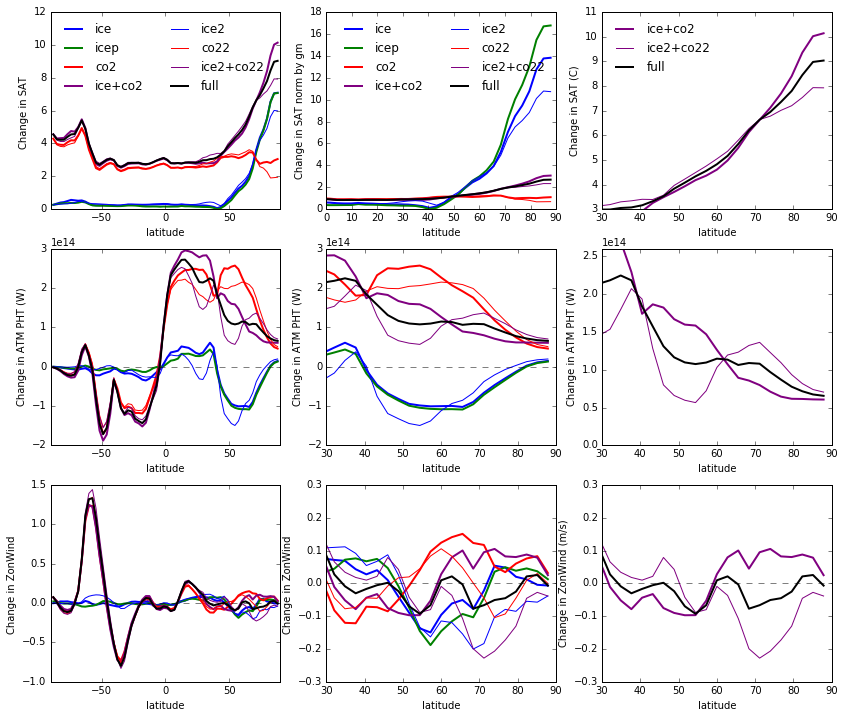

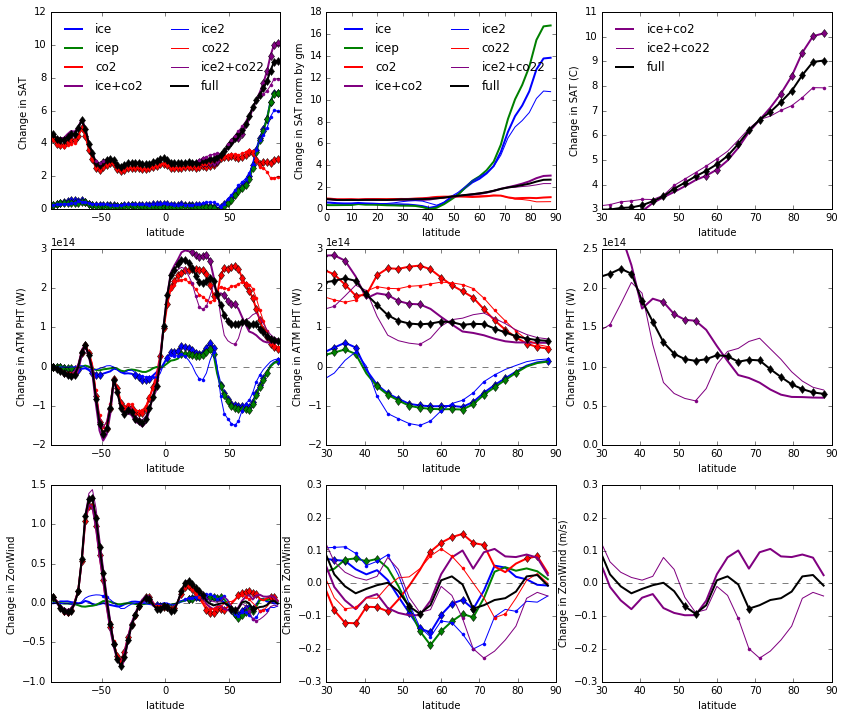

In [9]:
printtofile=False

suff='last100yrof200'

addpulse=True

fig,axs=plt.subplots(3,3,figsize=(14,12))
ax=axs[0,0]
plot_nc_linearity(nctmptmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(-90,90))
ax=axs[0,1]
plot_nc_linearity(nctmptmdt,ax,normbygm=True,ylab='SAT',latlim=(0,90),addpulse=addpulse)
ax=axs[0,2]
if sea=='ANN':
    dylim=(3,11)
elif sea=='DJF':
    dylim=(2,16)
else:
    dylim=None
plot_nc_linearity(nctmptmdt,ax,justcombo=True,dylim=dylim,latlim=(30,90),ylab='SAT',unit='(C)')

ax=axs[1,0]
plot_indir_linearity(ax,latlim=(-90,90),suppleg=True,addpulse=addpulse)#,dylim=(0,.3e15))
ax=axs[1,1]
if sea=='ANN':
    dylim1=(-2e14,3e14)
    dylim2=(0,2.6e14)
elif sea=='DJF':
    dylim1=(-3e14,6e14)
    dylim2=(0,5e14)
else:
    dylim=None
plot_indir_linearity(ax,dylim=dylim1,latlim=(30,90),suppleg=True,addpulse=addpulse)#,dylim=(0,.3e15))
ax=axs[1,2]
plot_indir_linearity(ax,justcombo=True,dylim=dylim2,latlim=(30,90),suppleg=True)#,dylim=(0,.3e15))

ax=axs[2,0]
plot_nc_linearity(ncsutmdt,ax,ylab='ZonWind',suppleg=True,addpulse=addpulse)#,latlim=(0,90))
ax=axs[2,1]
if sea=='ANN':
    dylim1=(-.3,.3)
    dylim2=(-.3,.3)
elif sea=='DJF':
    dylim1=(-.6,.5)
    dylim2=(-.6,.5)
else:
    dylim=None
plot_nc_linearity(ncsutmdt,ax,dylim=dylim1,latlim=(30,90),ylab='ZonWind',suppleg=True,addpulse=addpulse)#,latlim=(0,90))
ax=axs[2,2]
plot_nc_linearity(ncsutmdt,ax,justcombo=True,dylim=dylim2,latlim=(30,90),ylab='ZonWind',unit='(m/s)',suppleg=True)

if printtofile:
    if addpulse:
        fig.savefig('st_pht_su_allpulselinearity_withlat_' + sea + suff +'.pdf')
    else:
        fig.savefig('st_pht_su_alllinearity_withlat_' + sea + suff+'.pdf')
        
        
addsig=True

fig,axs=plt.subplots(3,3,figsize=(14,12))
ax=axs[0,0]
plot_nc_linearity(nctmpzmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(-90,90),addsig=addsig)
ax=axs[0,1]
plot_nc_linearity(nctmptmdt,ax,normbygm=True,ylab='SAT',latlim=(0,90),addpulse=addpulse)
ax=axs[0,2]
if sea=='ANN':
    dylim=(3,11)
elif sea=='DJF':
    dylim=(2,16)
else:
    dylim=None
plot_nc_linearity(nctmpzmdt,ax,justcombo=True,dylim=dylim,latlim=(30,90),ylab='SAT',unit='(C)',addsig=addsig)

ax=axs[1,0]
plot_indir_linearity(ax,latlim=(-90,90),suppleg=True,addpulse=addpulse,addsig=addsig)#,dylim=(0,.3e15))
ax=axs[1,1]
if sea=='ANN':
    dylim1=(-2e14,3e14)
    dylim2=(0,2.5e14)
elif sea=='DJF':
    dylim1=(-3e14,6e14)
    dylim2=(0,6e14)
else:
    dylim=None
plot_indir_linearity(ax,dylim=dylim1,latlim=(30,90),suppleg=True,addpulse=addpulse,addsig=addsig)#,dylim=(0,.3e15))
ax=axs[1,2]
plot_indir_linearity(ax,justcombo=True,dylim=dylim2,latlim=(30,90),suppleg=True,addsig=addsig)#,dylim=(0,.3e15))

ax=axs[2,0]
plot_nc_linearity(ncsuzmdt,ax,ylab='ZonWind',suppleg=True,addpulse=addpulse,addsig=addsig)#,latlim=(0,90))
ax=axs[2,1]
if sea=='ANN':
    dylim1=(-.3,.3)
    dylim2=(-.3,.3)
elif sea=='DJF':
    dylim1=(-.6,.5)
    dylim2=(-.6,.5)
else:
    dylim=None
plot_nc_linearity(ncsuzmdt,ax,dylim=dylim1,latlim=(30,90),ylab='ZonWind',
                  suppleg=True,addpulse=addpulse,addsig=addsig)#,latlim=(0,90))
ax=axs[2,2]
plot_nc_linearity(ncsuzmdt,ax,justcombo=True,dylim=dylim2,latlim=(30,90),
                  ylab='ZonWind',unit='(m/s)',suppleg=True,addsig=addsig)
if printtofile:
    if addpulse:
        fig.savefig('st_pht_su_allpulselinearity_withlat_' + sea + suff + 'sig.pdf')
    else:
        fig.savefig('st_pht_su_alllinearity_withlat_' + sea + suff + 'sig.pdf')
    
    

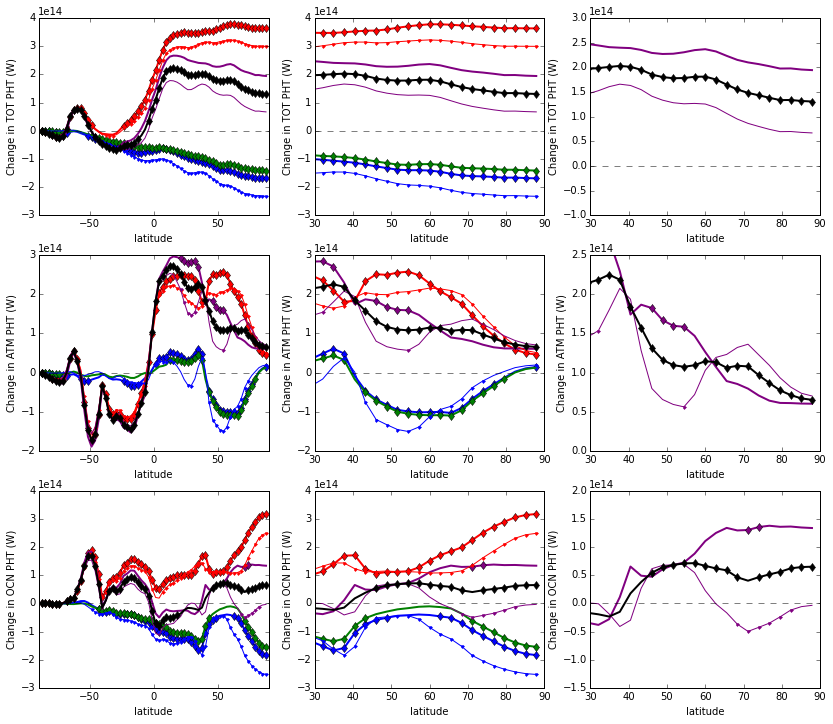

In [100]:
# Plot all components of indirect PHT (total, ocean, atmos)
printtofile=True
addsig=True

fig,axs=plt.subplots(3,3,figsize=(14,12))
ax=axs[0,0]
#   TOTAL
plot_indir_linearity(ax,latlim=(-90,90),suppleg=True,addpulse=addpulse,addsig=addsig,comp='tot')
ax=axs[0,1]
if sea=='ANN':
    dylim1=(-2e14,3e14)
    dylim2=(0,2.5e14)
elif sea=='DJF':
    dylim1=(-3e14,6e14)
    dylim2=(0,6e14)
else:
    dylim=None
plot_indir_linearity(ax,latlim=(30,90),suppleg=True,addpulse=addpulse,addsig=addsig,comp='tot')
ax=axs[0,2]
plot_indir_linearity(ax,justcombo=True,latlim=(30,90),suppleg=True,addsig=addsig,comp='tot')

ax=axs[1,0]
#   ATMOS
plot_indir_linearity(ax,latlim=(-90,90),suppleg=True,addpulse=addpulse,addsig=addsig)
ax=axs[1,1]
if sea=='ANN':
    dylim1=(-2e14,3e14)
    dylim2=(0,2.5e14)
elif sea=='DJF':
    dylim1=(-3e14,6e14)
    dylim2=(0,6e14)
else:
    dylim=None
plot_indir_linearity(ax,dylim=dylim1,latlim=(30,90),suppleg=True,addpulse=addpulse,addsig=addsig)
ax=axs[1,2]
plot_indir_linearity(ax,justcombo=True,dylim=dylim2,latlim=(30,90),suppleg=True,addsig=addsig)

ax=axs[2,0]
#   OCEAN
plot_indir_linearity(ax,latlim=(-90,90),suppleg=True,addpulse=addpulse,addsig=addsig,comp='ocn')
ax=axs[2,1]
if sea=='ANN':
    dylim1=(-2e14,3e14)
    dylim2=(0,2.5e14)
elif sea=='DJF':
    dylim1=(-3e14,6e14)
    dylim2=(0,6e14)
else:
    dylim=None
plot_indir_linearity(ax,latlim=(30,90),suppleg=True,addpulse=addpulse,addsig=addsig,comp='ocn')
ax=axs[2,2]
plot_indir_linearity(ax,justcombo=True,latlim=(30,90),suppleg=True,addsig=addsig,comp='ocn')

if printtofile:
    if addpulse:
        fig.savefig('totatmocnPHT_allpulselinearity_withlat_' + sea + suff +'sig.pdf')
    else:
        fig.savefig('totatmocnPHT_alllinearity_withlat_' + sea + suff +'sig.pdf')
    


COCO imbal 0.5 W/m2
COCO residual at 90N 0.317 PW
PIPI imbal 0.3 W/m2
PIPI residual at 90N 0.185 PW
PICO imbal -0.1 W/m2
PICO residual at 90N 0.017 PW
TOT (pipi my calc) imbal 0.1 W/m2
TOT residual at 90N 0.136 PW


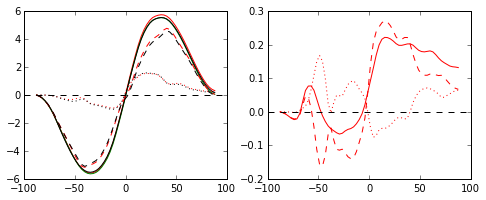

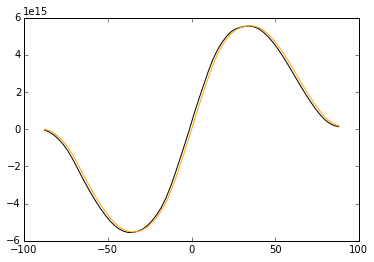

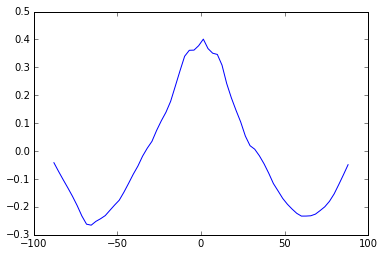

In [101]:
### USING BRIAN ROSE's FUNC
#  still have a huge diff from 0 in the difference calculations
#  what's the implication?

#   TOA
cotoanet = allflux['2xco22xco2ice']['nettoa'] 
coinftot = inferred_heat_transport(cotoanet, lat )
coimbal = np.average(cotoanet, weights=np.cos(np.deg2rad(lat)))
coinftotb = inferred_heat_transport(cotoanet-coimbal, lat )

print 'COCO imbal %0.1f W/m2' %coimbal
print 'COCO residual at 90N %0.3f PW' %coinftot[-1]

pitoanet = allflux['preipreiice']['nettoa'] 
piinftot = inferred_heat_transport(pitoanet, lat )
piimbal = np.average(pitoanet, weights=np.cos(np.deg2rad(lat)))
print 'PIPI imbal %0.1f W/m2' %piimbal
print 'PIPI residual at 90N %0.3f PW' %piinftot[-1]

picotoanet = allflux['prei2xco2iceb']['nettoa'] 
picoinftot = inferred_heat_transport(picotoanet, lat )
picoimbal = np.average(picotoanet, weights=np.cos(np.deg2rad(lat)))
print 'PICO imbal %0.1f W/m2' %picoimbal
print 'PICO residual at 90N %0.3f PW' %picoinftot[-1]


#    SFC
cosfcnet = allflux['2xco22xco2ice']['netsfc'] 
coinftoto = inferred_heat_transport(cosfcnet, lat )
pisfcnet = allflux['preipreiice']['netsfc'] 
piinftoto = inferred_heat_transport(pisfcnet, lat )






fig,axs=plt.subplots(1,2,figsize=(8,3))
ax=axs[0]
ax.plot(lat,coinftot,color='r')
ax.plot(lat,coinftotb,color='g')
ax.plot(lat,piinftot,color='k')
ax.plot(lat,coinftoto,color='r',linestyle='dotted')
ax.plot(lat,piinftoto,color='k',linestyle='dotted')
ax.plot(lat,coinftot-coinftoto,color='r',linestyle='dashed')
ax.plot(lat,piinftot-piinftoto,color='k',linestyle='dashed')
ax.axhline(y=0,color='k',linestyle='--')

ax=axs[1]
ax.plot(lat,coinftot-piinftot,color='r')
ax.plot(lat,coinftoto-piinftoto,color='r',linestyle='dotted')
ax.plot(lat,(coinftot-coinftoto)-(piinftot-piinftoto),color='r',linestyle='dashed')
ax.axhline(y=0,color='k',linestyle='--')


TOT,ATM,OCN = calc_indir_allpht(pitoanet,pisfcnet)
TOTimbal = np.average(TOT/1e15, weights=np.cos(np.deg2rad(lat)))
print 'TOT (pipi my calc) imbal %0.1f W/m2' %TOTimbal
print 'TOT residual at 90N %0.3f PW' %(TOT[-1]/1e15)


fig,ax=plt.subplots(1,1)
ax.plot(lat,TOT,color='k')
ax.plot(lat,piinftot*1e15,color='orange')

fig,ax=plt.subplots(1,1)
ax.plot(lat,TOT/1e15-piinftot)


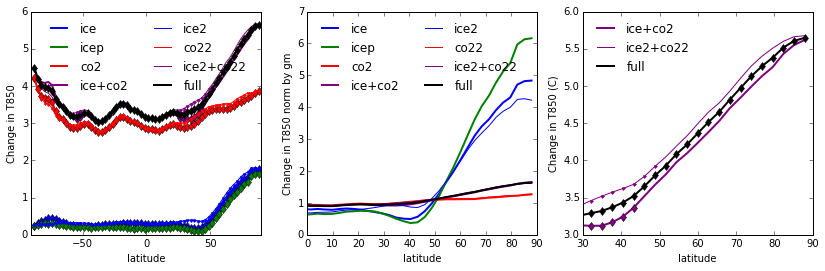

In [102]:
fig,axs=plt.subplots(1,3,figsize=(14,4))

ax=axs[0]
plot_nc_linearity(nctmp850zmdt,ax,ylab='T850',addpulse=addpulse,latlim=(-90,90),addsig=addsig)
ax=axs[1]
plot_nc_linearity(nctmp850tmdt,ax,normbygm=True,ylab='T850',latlim=(0,90),addpulse=addpulse)
ax=axs[2]
if sea=='ANN':
    dylim=(3,6)
elif sea=='DJF':
    dylim=(2,8)
else:
    dylim=None
plot_nc_linearity(nctmp850zmdt,ax,justcombo=True,dylim=dylim,latlim=(30,90),ylab='T850',unit='(C)',addsig=addsig)


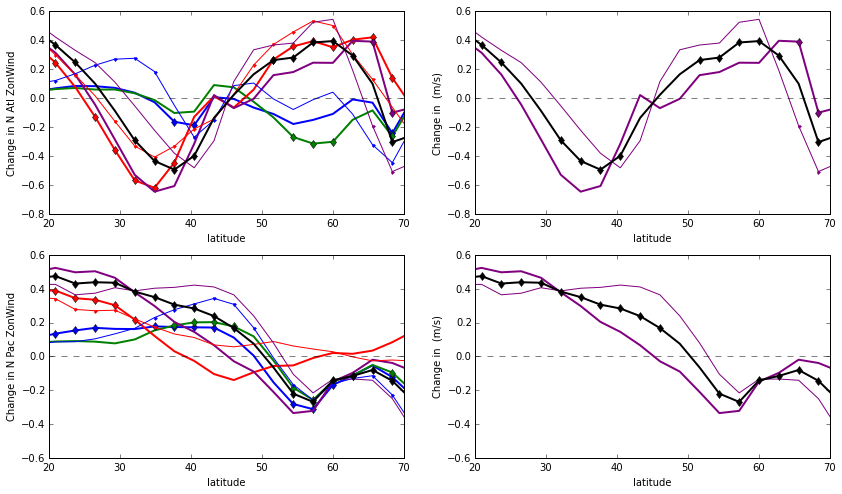

In [103]:
fig,axs=plt.subplots(2,2,figsize=(14,8))

ax=axs[0,0]

plot_nc_linearity(ncsunazmdt,ax,latlim=(20,70),ylab='N Atl ZonWind',
                  suppleg=True,addpulse=addpulse,addsig=addsig)#,latlim=(0,90))
ax=axs[0,1]
plot_nc_linearity(ncsunazmdt,ax,justcombo=True,latlim=(20,70),
                  ylab='',unit='(m/s)',suppleg=True,addsig=addsig)

ax=axs[1,0]

plot_nc_linearity(ncsupazmdt,ax,latlim=(20,70),ylab='N Pac ZonWind',
                  suppleg=True,addpulse=addpulse,addsig=addsig)#,latlim=(0,90))
ax=axs[1,1]
plot_nc_linearity(ncsupazmdt,ax,justcombo=True,latlim=(20,70),
                  ylab='',unit='(m/s)',suppleg=True,addsig=addsig)


In [104]:
# @@@@@
#  Arctic amplification (defined as the
# 67.5 N° to 90°N warming compared to the global average warming
# for 2081–2100 versus 1986–2005) peaks in early winter (November
# to December) with a CMIP5 RCP4.5 multi-model mean warming for
# 67.5°N to 90°N exceeding the global average by a factor of more than
# 4. 
#  IPCC AR5 Ch. 12 (section 12.4.3.1)


polamps={}
# Function takes control, pert

print nctmpzmdt['preipreiice'].shape
print nctmpdt['preipreiice'].shape
print nctmptmdt['preipreiice'].shape

if timeseries:
    verb=False
    pm = calc_polaramp(nctmptmdt['preipreiice'],nctmptmdt['prei2xco2iceb'],northof=60,verb=verb)
    #print 'ice polamp ' + str(pm)
    polamps['ice'] = pm

    pm = calc_polaramp(nctmptmdt['preipreiice'],nctmptmdt['pi2xco2ipulse'],northof=60,verb=verb)
    polamps['icep'] = pm

    pm = calc_polaramp(nctmptmdt['preipreiice'],nctmptmdt['2xco2preiice'],northof=60,verb=verb)
    #print 'co2 polamp ' + str(pm)
    polamps['co2'] = pm

    pm = calc_polaramp(2*nctmptmdt['preipreiice'],nctmptmdt['prei2xco2iceb']+nctmptmdt['2xco2preiice'],northof=60,verb=verb)
    #print 'ice+co2 polamp ' + str(pm)
    polamps['ice+co2'] = pm
    print ''

    pm = calc_polaramp(nctmptmdt['2xco2preiice'], nctmptmdt['2xco22xco2ice'], northof=60,verb=verb)
    polamps['ice2'] = pm

    pm = calc_polaramp(nctmptmdt['prei2xco2iceb'], nctmptmdt['2xco22xco2ice'], northof=60,verb=verb)
    polamps['co22'] = pm

    pm = calc_polaramp(nctmptmdt['2xco2preiice']+nctmptmdt['prei2xco2iceb'],2*nctmptmdt['2xco22xco2ice'],northof=60,verb=verb)
    polamps['ice2+co22'] = pm

    pm = calc_polaramp(nctmptmdt['preipreiice'],nctmptmdt['2xco22xco2ice'],northof=60,verb=verb)
    #print 'full polamp ' + str(pm)
    polamps['full'] = pm


else:
    verb=True
    pm = calc_polaramp(nctmpzmdt['preipreiice'],nctmpzmdt['prei2xco2iceb'],northof=60,verb=verb)
    #print 'ice polamp ' + str(pm)
    polamps['ice'] = pm

    pm = calc_polaramp(nctmpzmdt['preipreiice'],nctmpzmdt['pi2xco2ipulse'],northof=60,verb=verb)
    polamps['icep'] = pm

    pm = calc_polaramp(nctmpzmdt['preipreiice'],nctmpzmdt['2xco2preiice'],northof=60,verb=verb)
    #print 'co2 polamp ' + str(pm)
    polamps['co2'] = pm

    pm = calc_polaramp(2*nctmpzmdt['preipreiice'],nctmpzmdt['prei2xco2iceb']+nctmpzmdt['2xco2preiice'],northof=60,verb=verb)
    #print 'ice+co2 polamp ' + str(pm)
    polamps['ice+co2'] = pm
    print ''

    pm = calc_polaramp(nctmpzmdt['2xco2preiice'], nctmpzmdt['2xco22xco2ice'], northof=60,verb=verb)
    polamps['ice2'] = pm

    pm = calc_polaramp(nctmpzmdt['prei2xco2iceb'], nctmpzmdt['2xco22xco2ice'], northof=60,verb=verb)
    polamps['co22'] = pm

    pm = calc_polaramp(nctmpzmdt['2xco2preiice']+nctmpzmdt['prei2xco2iceb'],2*nctmpzmdt['2xco22xco2ice'],northof=60,verb=verb)
    polamps['ice2+co22'] = pm

    pm = calc_polaramp(nctmpzmdt['preipreiice'],nctmpzmdt['2xco22xco2ice'],northof=60,verb=verb)
    #print 'full polamp ' + str(pm)
    polamps['full'] = pm

if not timeseries:
    print polamps

(100, 64)
(100, 64, 129)
(64,)



(64,)
(64,)


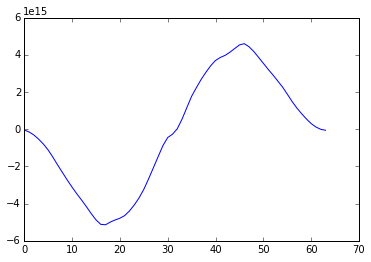

In [105]:
# --------- indirect PHT ------------------
print allflux['preipreiice']['nettoa'].shape # no time dim in this. use allfluxtm[] for time.
maxpht={}
# add 'b' to var name to avoid overwriting
coctlb = calc_indir_pht(allflux['2xco22xco2ice']['nettoa'],allflux['2xco22xco2ice']['netsfc'])
pictlb = calc_indir_pht(allflux['preipreiice']['nettoa'],allflux['preipreiice']['netsfc'])
        
print pictlb.shape
plt.figure(); plt.plot(pictlb)

picob = calc_indir_pht(allflux['prei2xco2iceb']['nettoa'],allflux['prei2xco2iceb']['netsfc'])
picopb = calc_indir_pht(allflux['pi2xco2ipulse']['nettoa'],allflux['pi2xco2ipulse']['netsfc'])
copib = calc_indir_pht(allflux['2xco2preiice']['nettoa'],allflux['2xco2preiice']['netsfc'])

In [106]:
    
maxlat = 40 # find max PHT north of this lat

iceb = picob - pictlb
ix= np.argmax(np.abs(iceb[lat>maxlat]))
maxpht['ice'] = iceb[lat>maxlat][ix]/1e14

icepb = picopb - pictlb   
ix= np.argmax(np.abs(icepb[lat>maxlat]))
maxpht['icep'] = icepb[lat>maxlat][ix]/1e14
   
co2b = copib - pictlb # shouldn't need to do this b/c > 0
ix= np.argmax(np.abs(co2b[lat>maxlat]))
maxpht['co2'] = co2b[lat>maxlat][ix]/1e14
    
com = iceb+co2b
fullb = coctlb - pictlb 

maxpht['full'] = np.max(np.abs(fullb[lat>maxlat]))/1e14
# don't need to get index of max first b/c they should all be > 0    
ice2b = coctlb - copib 
co22b = coctlb - picob 
com2 = ice2b+co22b

ix= np.argmax(np.abs(ice2b[lat>maxlat]))   
maxpht['ice2'] = ice2b[lat>maxlat][ix]/1e14
    
maxpht['co22'] = np.max(np.abs(co22b[lat>maxlat]))/1e14
maxpht['ice+co2'] = np.max(np.abs(com[lat>maxlat]))/1e14
maxpht['ice2+co22'] = np.max(np.abs(com2[lat>maxlat]))/1e14
   
iddt={'MaxPHT': maxpht, 'PolAmp':polamps}
iddf = pd.DataFrame(iddt)
print 'INDIRECT'    
print iddf

# -------------------------------------------
# --------- direct PHT ------------------
maxdpht={}
# add 'b' to var name to avoid overwriting

icedb = totpht['prei2xco2iceb'] - totpht['preipreiice']    
ix= np.argmax(np.abs(icedb[lat>maxlat]))
maxdpht['ice'] = icedb[lat>maxlat][ix]/1e14

icepdb = totpht['pi2xco2ipulse'] - totpht['preipreiice']    
ix= np.argmax(np.abs(icepdb[lat>maxlat]))
maxdpht['icep'] = icepdb[lat>maxlat][ix]/1e14

co2db = totpht['2xco2preiice'] - totpht['preipreiice']   
ix= np.argmax(np.abs(co2db[lat>maxlat]))
maxdpht['co2'] = co2db[lat>maxlat][ix]/1e14

comd = icedb+co2db
maxdpht['ice+co2'] = np.max(np.abs(comd[lat>maxlat]))/1e14
fulldb = totpht['2xco22xco2ice'] - totpht['preipreiice']    
maxdpht['full'] = np.max(np.abs(fulldb[lat>maxlat]))/1e14

ice2db = totpht['2xco22xco2ice'] - totpht['2xco2preiice'] 
ix= np.argmax(np.abs(ice2db[lat>maxlat]))
maxdpht['ice2'] = ice2db[lat>maxlat][ix]/1e14

co22db = totpht['2xco22xco2ice'] - totpht['prei2xco2iceb']
com2d = ice2db+co22db
print com2d[lat>maxlat]

maxdpht['co22'] = np.max(np.abs(co22db[lat>maxlat]))/1e14
maxdpht['ice2+co22'] = np.max(np.abs(com2d[lat>maxlat]))/1e14

ddt={'MaxDPHT': maxdpht, 'PolAmp':polamps}
ddf = pd.DataFrame(ddt)
print 'DIRECT'
print ddf


INDIRECT
             MaxPHT    PolAmp
co2        2.566977  1.126088
co22       2.147712  1.084920
full       1.835690  1.865773
ice       -1.022123  6.189050
ice+co2    1.863236  1.911115
ice2      -1.492378  5.573316
ice2+co22  1.933093  1.821624
icep      -1.087474  7.190626
[  3.30606400e+14   2.21450101e+14   1.53367800e+14   6.34744535e+13
   8.19272644e+13   3.66840684e+13   3.46227778e+13   1.16655824e+12
   7.12652902e+13   3.99008753e+13   7.87579069e+13   6.66083781e+13
   6.21195684e+13   3.94002988e+13   4.90473471e+13   2.30346493e+13
   8.53611495e+12  -5.12558711e+10]
DIRECT
            MaxDPHT    PolAmp
co2        3.067221  1.126088
co22       3.008835  1.084920
full       3.267679  1.865773
ice       -1.499593  6.189050
ice+co2    3.229295  1.911115
ice2      -1.746981  5.573316
ice2+co22  3.306064  1.821624
icep      -1.548307  7.190626


-1.42582379858 4.5474140981 -0.969553356504 6.8958527767e-05
regress pval,rval: 6.8958527767e-05 -0.969553356504
-1.17107893557 3.98526647194 -0.851233730075 0.0673215181884
regress pval,rval: 0.0673215181884 -0.851233730075
-0.98562991277 4.71093055659 -0.967705483584 8.2176474492e-05
regress pval,rval: 8.2176474492e-05 -0.967705483584
3.05263494924 -8.13271200089 0.951560852377 0.012704210158
regress pval,rval: 0.012704210158 0.951560852377


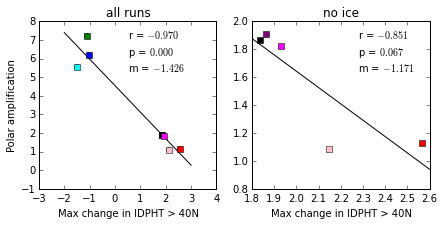

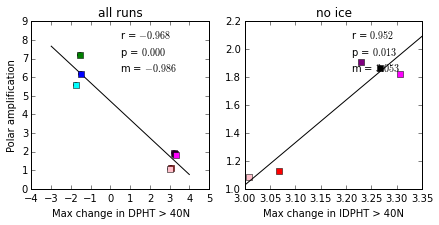

In [107]:
# =============== FIGURES ==================

cases = ('ice','co2','ice+co2','full','ice2','co22','ice2+co22','icep')
clrs = ('b','r','purple','k','cyan','pink','magenta','g')
casesnoi = ('co2','ice+co2','full','co22','ice2+co22')
clrsnoi = ('r','purple','k','pink','magenta')
 
# Indirect PHT (IDPHT)
fig,axs = plt.subplots(1,2,figsize=(7,3))
ax=axs[0]
ax.scatter(iddf['MaxPHT'],iddf['PolAmp'])

mm,bb,rv,pv = cutl.regress(iddf['MaxPHT'],iddf['PolAmp'])
print mm,bb,rv,pv
cplt.add_regressline(iddf['MaxPHT'],iddf['PolAmp'],ax=ax)
for ii,cc in enumerate(cases):
    ax.plot(iddf['MaxPHT'][cc],iddf['PolAmp'][cc],marker='s',color=clrs[ii])
ax.set_xlabel('Max change in IDPHT > ' + str(maxlat) + 'N')
ax.set_ylabel('Polar amplification')
ax.annotate('r = $%.3f$'%(rv),xy=(.5,.9),xycoords='axes fraction')
ax.annotate('p = $%.3f$'%(pv),xy=(.5,.8),xycoords='axes fraction')
ax.annotate('m = $%.3f$'%(mm),xy=(.5,.7),xycoords='axes fraction')
ax.set_title('all runs')
    
ax=axs[1]
dat = np.zeros((len(casesnoi),2))
for ii,cc in enumerate(casesnoi):
    ax.plot(iddf['MaxPHT'][cc],iddf['PolAmp'][cc],marker='s',color=clrsnoi[ii])
    dat[ii,:] = iddf['MaxPHT'][cc],iddf['PolAmp'][cc]
mmnoi,bbnoi,rvnoi,pvnoi = cutl.regress(dat[:,0],dat[:,1])
print mmnoi,bbnoi,rvnoi,pvnoi
cplt.add_regressline(dat[:,0],dat[:,1],ax=ax)
ax.set_xlabel('Max change in IDPHT > ' + str(maxlat) + 'N')
ax.annotate('r = $%.3f$'%(rvnoi),xy=(.6,.9),xycoords='axes fraction')
ax.annotate('p = $%.3f$'%(pvnoi),xy=(.6,.8),xycoords='axes fraction')
ax.annotate('m = $%.3f$'%(mmnoi),xy=(.6,.7),xycoords='axes fraction')
ax.set_title('no ice')



# Direct PHT (IDPHT)
fig,axs = plt.subplots(1,2,figsize=(7,3))
ax=axs[0]
ax.scatter(ddf['MaxDPHT'],ddf['PolAmp'])

mm,bb,rv,pv = cutl.regress(ddf['MaxDPHT'],ddf['PolAmp'])
print mm,bb,rv,pv
cplt.add_regressline(ddf['MaxDPHT'],ddf['PolAmp'],ax=ax)
for ii,cc in enumerate(cases):
    ax.plot(ddf['MaxDPHT'][cc],ddf['PolAmp'][cc],marker='s',color=clrs[ii])
ax.set_xlabel('Max change in DPHT > ' + str(maxlat) + 'N')
ax.set_ylabel('Polar amplification')
ax.annotate('r = $%.3f$'%(rv),xy=(.5,.9),xycoords='axes fraction')
ax.annotate('p = $%.3f$'%(pv),xy=(.5,.8),xycoords='axes fraction')
ax.annotate('m = $%.3f$'%(mm),xy=(.5,.7),xycoords='axes fraction')
ax.set_title('all runs')

ax=axs[1]
dat = np.zeros((len(casesnoi),2))
for ii,cc in enumerate(casesnoi):
    ax.plot(ddf['MaxDPHT'][cc],ddf['PolAmp'][cc],marker='s',color=clrsnoi[ii])
    dat[ii,:] = ddf['MaxDPHT'][cc],ddf['PolAmp'][cc]
mmnoi,bbnoi,rvnoi,pvnoi = cutl.regress(dat[:,0],dat[:,1])
print mmnoi,bbnoi,rvnoi,pvnoi
cplt.add_regressline(dat[:,0],dat[:,1],ax=ax)
ax.set_xlabel('Max change in IDPHT > ' + str(maxlat) + 'N')
ax.annotate('r = $%.3f$'%(rvnoi),xy=(.6,.9),xycoords='axes fraction')
ax.annotate('p = $%.3f$'%(pvnoi),xy=(.6,.8),xycoords='axes fraction')
ax.annotate('m = $%.3f$'%(mmnoi),xy=(.6,.7),xycoords='axes fraction')
ax.set_title('no ice')

In [108]:
# for the LE data!!  should change the func name to specify... @@
def load_field(fdict,casename,timesel,seas=None,mo=0,ftype='fullts',orig=None,
               calc=None,zonal=False,conv=1,local=False,verb=False):
    
    """ TAKEN FROM load_field() in canesm_le_composite.py/pi_pdf_uncertainty.py

        returns [numens x space.flat] or [numens]

    """

    ledat = le.load_LEdata(fdict,casename,timesel=timesel, 
                           rettype='ndarray',conv=conv,ftype=ftype,orig=orig,
                           local=local,verb=verb,zonal=zonal)
    print ledat.shape #@@@@@@
    
    # time needs to be first dimension
    try:
        if ledat.ndim==2:
            ledat = ledat.T # time x ens
        elif ledat.ndim==3:
            ledat = np.transpose(ledat,(1,0,2)) # time x ens x space
            """if zonal:
                # do a zonal average before returning. requires reshaping
                nt = ledat.shape[0]
                nens = ledat.shape[1]
                nspace = ledat.shape[2]
                print nt,nens,nspace
                nlat = con.get_t63lat().shape
                nlon = con.get_t63lon().shape
                ledat = np.reshape(ledat,(nt,nens,nlat,nlon))
                ledat = np.mean(ledat,axis=-1)
                print ledat.shape #@@@@@"""
        else:
            print 'Loaded data is not 2 or 3 dimensions. Do not understand.'
            raise Exception
    except:
        raise

    if seas==None and mo==0:
        lesea=ledat        
    else:
    
        lesea = cutl.seasonalize(ledat,season=seas,mo=mo) # time x numens x space.flat
  
        
    if calc!=None and calc=='trend':
        
        mm,bb=cutl.trend_monthly(lesea) # should return 12 x numens x space.flat
        return lesea,mm,bb
    else:
    
        return lesea

import loadLE as le

le=reload(le)

addle=False
local=True

if addle:
    casename='historical'
    # 1 v 2: past historical comparison
    timesel1='1950-01-01,1969-12-31' # 20 years
    timesel2='1996-01-01,2015-12-31' # 20 years
    # 3 vs 4 : standard future projection comparison. 100 years apart
    # 3b vs 4 : hoping "control" time period already doesn't have much sea ice
    #           to see how PHT changes after ice has gone away. Check ice.
    timesel3='1981-01-01,2000-12-31' # 20 years
    timesel3b='2051-01-01,2070-12-31' # 20 years
    timesel4='2081-01-01,2100-12-31' # 20 years
    
    
    fdictsfc = {'field': 'netsfc', 'ncfield': 'netsfc', 'comp': 'Amon'}
    conv=-1 # so it is + into sfc
    lparams = {'seas':sea, 'verb':False, 'ftype':'fullts','orig':None,
               'local':local,'zonal':True}    
    lesfcc = load_field(fdictsfc, 'historical', timesel1,conv=conv,**lparams)
    lesfcp = load_field(fdictsfc, 'historical', timesel2,conv=conv,**lparams)
    print 'zonal mean, seasonalize shape ' + str(lesfcc.shape),str(lesfcp.shape)
    lesfcctm = lesfcc.mean(axis=0)
    lesfcptm = lesfcp.mean(axis=0)
    print 'final shape ' + str(lesfcctm.shape),str(lesfcptm.shape)
    
    fdicttoa = {'field': 'nettoa', 'ncfield': 'nettoa', 'comp': 'Amon'}
    conv=1 
    letoac = load_field(fdicttoa, 'historical', timesel1,conv=conv,**lparams)
    letoap = load_field(fdicttoa, 'historical', timesel2,conv=conv,**lparams)
    print 'zonal mean, seasonalize shape ' + str(letoac.shape),str(letoap.shape)
    letoactm = letoac.mean(axis=0)
    letoaptm = letoap.mean(axis=0)
    
    # ------ future time periods
    conv=-1 # so it is + into sfc
    lparamsf = {'seas':sea, 'verb':True, 'ftype':'202101-210012','orig':None,
               'local':local,'zonal':True}    
    lesfcc3 = load_field(fdictsfc, 'historical', timesel3,conv=conv,**lparams)
    lesfcp3 = load_field(fdictsfc, 'historical', timesel4,conv=conv,**lparamsf)
    print 'zonal mean, seasonalize shape ' + str(lesfcc.shape),str(lesfcp.shape)
    lesfcc3tm = lesfcc3.mean(axis=0)
    lesfcp3tm = lesfcp3.mean(axis=0)
    print 'final shape ' + str(lesfcc3tm.shape),str(lesfcp3tm.shape)
    
    conv=1 
    letoac3 = load_field(fdicttoa, 'historical', timesel3,conv=conv,**lparams)
    letoap3 = load_field(fdicttoa, 'historical', timesel4,conv=conv,**lparamsf)
    print 'zonal mean, seasonalize shape ' + str(letoac3.shape),str(letoap3.shape)
    letoac3tm = letoac3.mean(axis=0)
    letoap3tm = letoap3.mean(axis=0)
    
    
    # Now get SAT for polar amp   
    fdicttas = {'field': 'tas', 'ncfield': 'tas', 'comp': 'Amon'}
    conv=1
    letaszc = load_field(fdicttas, 'historical', timesel1,conv=conv,**lparams)
    letaszp = load_field(fdicttas, 'historical', timesel2,conv=conv,**lparams)
    # should be time x ens x lat
    letaszctm = letaszc.mean(axis=0) # ens x lat
    letaszptm = letaszp.mean(axis=0) # ens x lat
    
    lepolamp = calc_polaramp(letaszctm,letaszptm,northof=60)
    
    # future
    letaszc3 = load_field(fdicttas, 'historical', timesel3,conv=conv,**lparams)
    letaszp3 = load_field(fdicttas, 'historical', timesel4,conv=conv,**lparamsf)
    # should be time x ens x lat
    letaszc3tm = letaszc3.mean(axis=0) # ens x lat
    letaszp3tm = letaszp3.mean(axis=0) # ens x lat
    
    lepolamp3 = calc_polaramp(letaszc3tm,letaszp3tm,northof=60)
    

In [109]:
if addle:
    # get intermediate future timeperiod
    
    conv=-1 # so it is + into sfc
    lparamsf = {'seas':sea, 'verb':False, 'ftype':'202101-210012','orig':None,
               'local':local,'zonal':True}    
    lesfcc3b = load_field(fdictsfc, 'historical', timesel3b,conv=conv,**lparamsf)
    #lesfcp3 = load_field(fdictsfc, 'historical', timesel4,conv=conv,**lparamsf)
    lesfcc3btm = lesfcc3b.mean(axis=0)
    #lesfcp3tm = lesfcp3.mean(axis=0)
    
    conv=1 
    letoac3b = load_field(fdicttoa, 'historical', timesel3b,conv=conv,**lparamsf)
    #letoap3 = load_field(fdicttoa, 'historical', timesel4,conv=conv,**lparamsf)
    letoac3btm = letoac3b.mean(axis=0)
    #letoap3tm = letoap3.mean(axis=0)
    
    
    letaszc3b = load_field(fdicttas, 'historical', timesel3b,conv=conv,**lparamsf)
    #letaszp3 = load_field(fdicttas, 'historical', timesel4,conv=conv,**lparamsf)
    # should be time x ens x lat
    letaszc3btm = letaszc3b.mean(axis=0) # ens x lat
    #letaszp3tm = letaszp3.mean(axis=0) # ens x lat
    
    lepolamp3b = calc_polaramp(letaszc3btm,letaszp3tm,northof=60)

In [110]:
if addle:
    
    lephtc = calc_indir_pht(letoactm,lesfcctm)
    lephtp = calc_indir_pht(letoaptm,lesfcptm)
    lephtd = lephtp - lephtc
    
    # calc max PHT north of 40
    maxlat=40
    phtnth = lephtd[:,lat>maxlat]    
    lemaxpht = phtnth.max(axis=1)/1e14
    print lemaxpht.shape

    
    # global mean TAS anom
    legmtd = calc_gmanom(letaszctm,letaszptm)
    print legmtd.shape

    
    # ---- future
    lephtc3 = calc_indir_pht(letoac3tm,lesfcc3tm)
    lephtp3 = calc_indir_pht(letoap3tm,lesfcp3tm)
    lephtd3 = lephtp3 - lephtc3
    
    # calc max PHT north of 40
    phtnth3 = lephtd3[:,lat>maxlat]    
    lemaxpht3 = phtnth3.max(axis=1)/1e14
    print lemaxpht3.shape

    
    # global mean TAS anom
    legmtd3 = calc_gmanom(letaszc3tm,letaszp3tm)
    print legmtd3.shape

    # ---  intermediate future
    lephtc3b = calc_indir_pht(letoac3btm,lesfcc3btm)
    #lephtp3 = calc_indir_pht(letoap3tm,lesfcp3tm)
    lephtd3b = lephtp3 - lephtc3b
    
    # calc max PHT north of 40
    phtnth3b = lephtd3b[:,lat>maxlat]    
    lemaxpht3b = phtnth3b.max(axis=1)/1e14
    print lemaxpht3b.shape

    
    # global mean TAS anom
    legmtd3b = calc_gmanom(letaszc3btm,letaszp3tm)
    print legmtd3b.shape

In [111]:
if addle:
    printtofile=True
    
    # testing
    #fig=plot_dirpht_all()
    
    fig,axs = plt.subplots(1,2, figsize=(13,5))
    ax=axs[0]
    plot_indirpht_climo(ax) # RLX runs
    ret = ax.plot(lat,lephtc.T,color='purple')
    ret = ax.plot(lat,lephtp.T,color='orange')
    ret = ax.plot(lat,lephtc3.T,color='purple',linestyle='--')
    ret = ax.plot(lat,lephtp3.T,color='orange',linestyle='--')
    ret = ax.plot(lat,lephtc3b.T,color='pink',linestyle='--')
    
    ax=axs[1]
    plot_indirpht_diff(ax)
    ret = ax.plot(lat,lephtd.T,color='0.5',alpha=0.5)
    ret = ax.plot(lat,lephtd3.T,color='orange',alpha=0.3)
    ret = ax.plot(lat,lephtd3b.T,color='pink',alpha=0.3)
    fig.suptitle(sea)
    if printtofile:
        fig.savefig('PHTclimo_diff_rlxandLE_' + sea + suff +'.pdf')
        
    #fig,ax = plt.subplots(1,1)
    #ret = ax.plot(lat,lephtd.T,color='k')

    fig,axs = plt.subplots(1,2,figsize=(13,5))
    ax=axs[0]
    ret = ax.plot(lat,(letaszptm-letaszctm).T,color='0.5',alpha=0.5)
    ret = ax.plot(lat,(letaszp3tm-letaszc3tm).T,color='orange',alpha=0.3)
    ret = ax.plot(lat,(letaszp3tm-letaszc3btm).T,color='pink',alpha=0.3)
    plot_nc_linearity(nctmptmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(-90,90))
    ax=axs[1]
    ret = ax.plot(lat,(letaszptm-letaszctm).T,color='0.5',alpha=0.5)
    ret = ax.plot(lat,(letaszp3tm-letaszc3tm).T,color='orange',alpha=0.3)
    ret = ax.plot(lat,(letaszp3tm-letaszc3btm).T,color='pink',alpha=0.3)
    plot_nc_linearity(nctmptmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(40,90))
    fig.suptitle(sea)
    if printtofile:
        fig.savefig('tasdiff_rlxandLE_histfuture_' + sea + suff +'.pdf')
    
    # normalized:
    fig,axs = plt.subplots(1,2,figsize=(13,5))
    ax=axs[0]
    ret = ax.plot(lat,(letaszptm-letaszctm).T / legmtd,color='0.5',alpha=0.2)
    ret = ax.plot(lat,(letaszp3tm-letaszc3tm).T / legmtd3,color='orange',alpha=0.2)
    ret = ax.plot(lat,(letaszp3tm-letaszc3btm).T / legmtd3b,color='pink',alpha=0.2)
    plot_nc_linearity(nctmptmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(-90,90),normbygm=True)
    ax=axs[1]
    ret = ax.plot(lat,(letaszptm-letaszctm).T / legmtd,color='0.5',alpha=0.2)
    ret = ax.plot(lat,(letaszp3tm-letaszc3tm).T / legmtd3,color='orange',alpha=0.2)
    ret = ax.plot(lat,(letaszp3tm-letaszc3btm).T / legmtd3b,color='pink',alpha=0.3)
    plot_nc_linearity(nctmptmdt,ax,ylab='SAT',addpulse=addpulse,latlim=(40,90),normbygm=True)
    if sea=='DJF':
        ax.set_ylim((-2,8))
    elif sea=='ANN':
        ax.set_ylim((-2,4))
    fig.suptitle(sea)
    if printtofile:
        fig.savefig('tasdiffnorm_rlxandLE_histfuture' + sea + suff +'.pdf')
    
    fig,ax = plt.subplots(1,1)
    ax.scatter(lemaxpht,lepolamp,color='0.5',alpha=0.5)
    ax.scatter(lemaxpht3,lepolamp3,color='orange',alpha=0.3)
    ax.scatter(lemaxpht3b,lepolamp3b,color='pink',alpha=0.3)
    
    
    # RLX scatter plot + LE data
    fig,axs = plt.subplots(1,2,figsize=(7,3))
    ax=axs[0]
    ax.scatter(iddf['MaxPHT'],iddf['PolAmp'])

    mm,bb,rv,pv = cutl.regress(iddf['MaxPHT'],iddf['PolAmp'])
    print mm,bb,rv,pv
    cplt.add_regressline(iddf['MaxPHT'],iddf['PolAmp'],ax=ax)
    for ii,cc in enumerate(cases):
        ax.plot(iddf['MaxPHT'][cc],iddf['PolAmp'][cc],marker='s',color=clrs[ii])
    ax.set_xlabel('Max change in IDPHT > ' + str(maxlat) + 'N')
    ax.set_ylabel('Polar amplification')
    ax.annotate('r = $%.3f$'%(rv),xy=(.5,.9),xycoords='axes fraction')
    ax.annotate('p = $%.3f$'%(pv),xy=(.5,.8),xycoords='axes fraction')
    ax.annotate('m = $%.3f$'%(mm),xy=(.5,.7),xycoords='axes fraction')
    ax.set_title('all runs')
    
    ax.scatter(lemaxpht,lepolamp,marker='o',color='0.5',alpha=0.5)
    ax.scatter(lemaxpht3,lepolamp3,marker='o',color='orange',alpha=0.5)
    ax.scatter(lemaxpht3b,lepolamp3b,marker='o',color='pink',alpha=0.5)
    
    ax=axs[1]
    dat = np.zeros((len(casesnoi),2))
    for ii,cc in enumerate(casesnoi):
        ax.plot(iddf['MaxPHT'][cc],iddf['PolAmp'][cc],marker='s',color=clrsnoi[ii])
        dat[ii,:] = iddf['MaxPHT'][cc],iddf['PolAmp'][cc]
    mmnoi,bbnoi,rvnoi,pvnoi = cutl.regress(dat[:,0],dat[:,1])
    print mmnoi,bbnoi,rvnoi,pvnoi
    cplt.add_regressline(dat[:,0],dat[:,1],ax=ax)
    ax.set_xlabel('Max change in IDPHT > ' + str(maxlat) + 'N')
    ax.annotate('r = $%.3f$'%(rvnoi),xy=(.6,.9),xycoords='axes fraction')
    ax.annotate('p = $%.3f$'%(pvnoi),xy=(.6,.8),xycoords='axes fraction')
    ax.annotate('m = $%.3f$'%(mmnoi),xy=(.6,.7),xycoords='axes fraction')
    ax.set_title('no ice')

    ax.scatter(lemaxpht,lepolamp,marker='o',color='0.5',alpha=0.5)
    ax.scatter(lemaxpht3,lepolamp3,marker='o',color='orange',alpha=0.5)
    ax.scatter(lemaxpht3b,lepolamp3b,marker='o',color='pink',alpha=0.5)

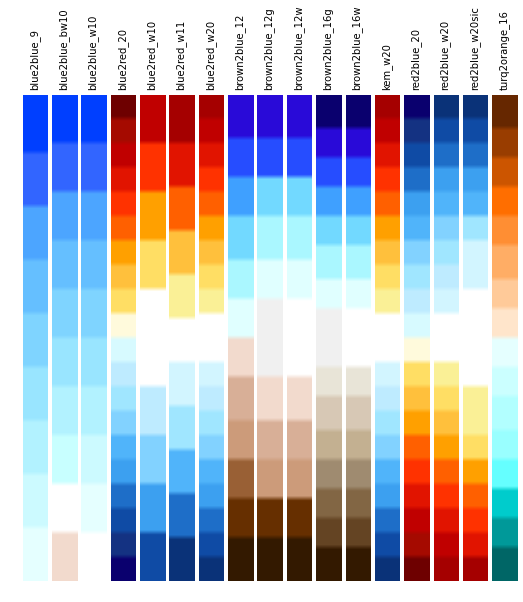

In [112]:
import cccmacmaps as ccm
ccm.show_cccmacms()

In [113]:
print ctlcontsq
print ctlcontsw

print (ctlcontsq < 1.).any() and (ctlcontsq > -1.).any()
print (ctlcontst < 1.).any() and (ctlcontst > -1.).any()
print (ctlcontsw < 1.).any() and (ctlcontsw > -1.).any()


[  0.5   1.    2.    4.    6.    8.   10. ]
[-3  2  7 12 17 22 27]
True
False
True


(0, 100)
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
(-90, 90)
prei2xco2iceb
pi2xco2ipulse
2xco2preiice


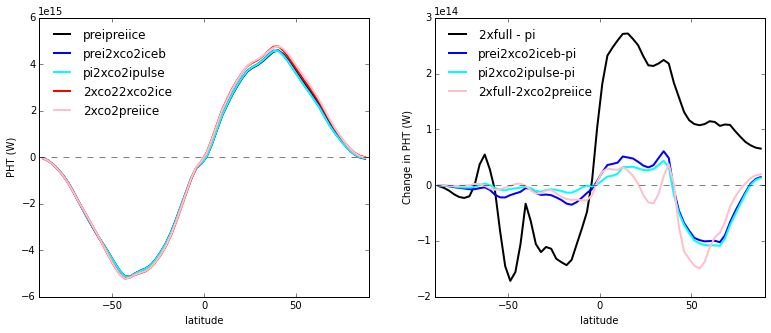

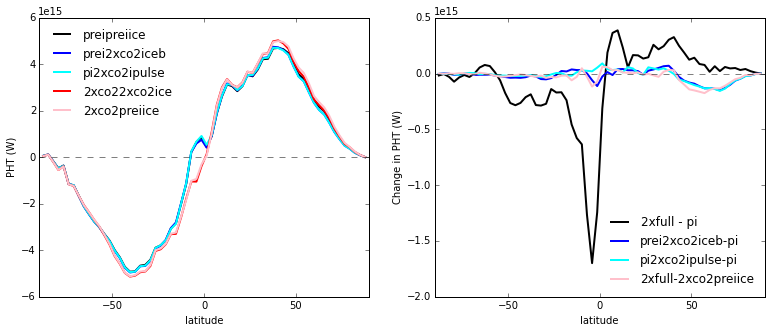

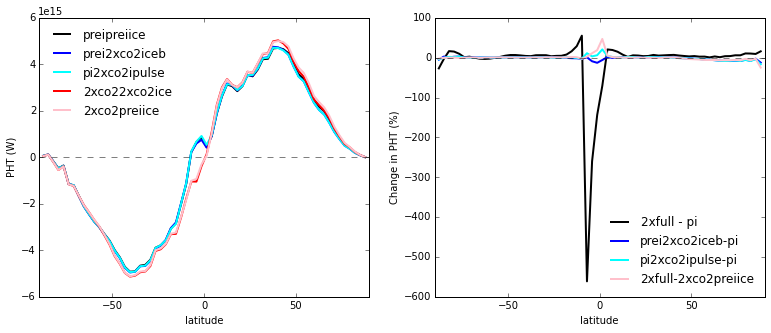

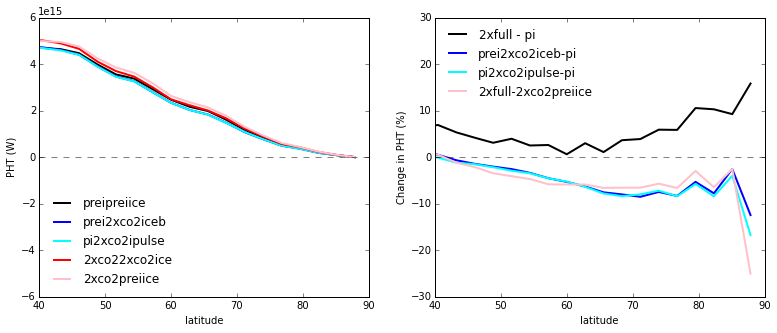

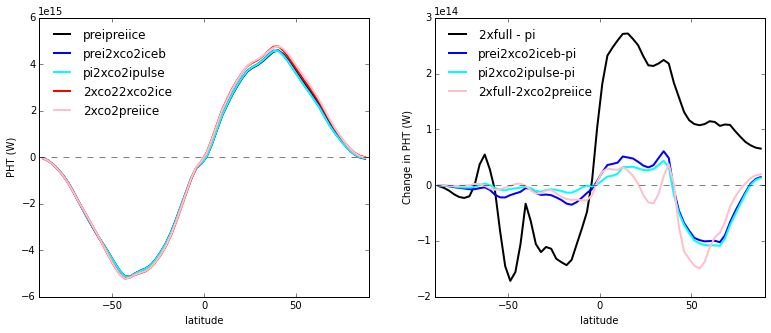

In [114]:
print seltime

plot_dirpht_all()
plot_dirpht_all(pct=True)
plot_dirpht_all(pct=True, latlim=(40,90),dylim=(-30,30))


plot_indirpht_all()

prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
prei2xco2iceb
pi2xco2ipulse
2xco2preiice


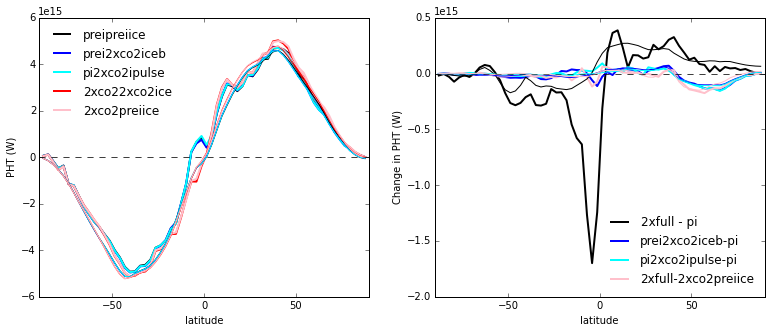

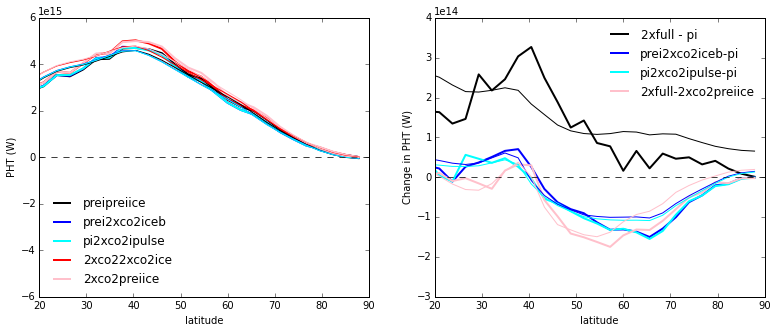

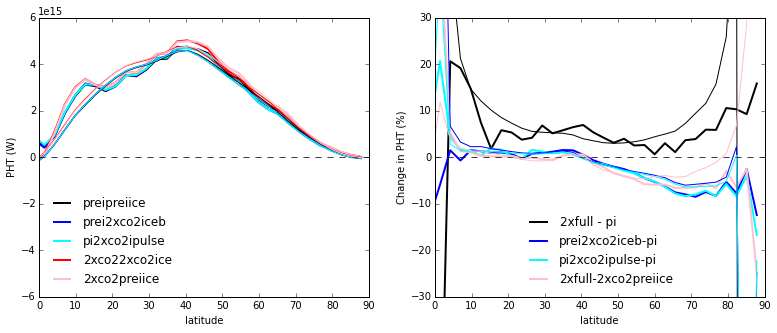

In [115]:
printtofile=False

fig = plot_pht_all()
if printtofile:
    fig.savefig('PHTclimodiff_all_' + sea + str(seltime[0]) + '-'+str(seltime[1]-1) + '_-90to90b.pdf')
    
fig = plot_pht_all(latlim=(20,90),dylim=(-.3e15,.4e15),pct=False)
if printtofile:
    fig.savefig('PHTclimodiff_all_' + sea + str(seltime[0]) + '-'+str(seltime[1]-1) + '_0to90b.pdf')

fig = plot_pht_all(latlim=(0,90),pct=True,dylim=(-30,30))
if printtofile:
    fig.savefig('PHTclimodiffpct_all_' + sea + str(seltime[0]) + '-'+str(seltime[1]-1) + '_0to90b.pdf')


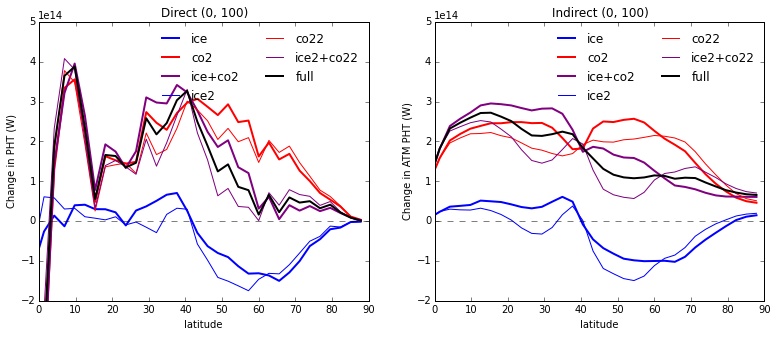

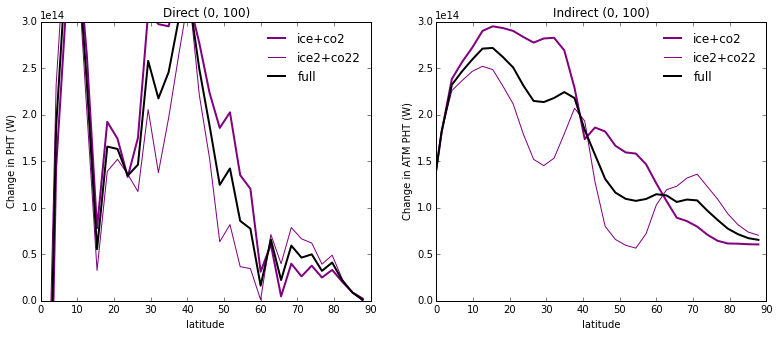

In [116]:
printtofile=True
latlim=(0,90)

fig,axs=plt.subplots(1,2, figsize=(13,5))
ax=axs[0]
plot_dir_linearity(ax,latlim=latlim,dylim=(-.2e15,.5e15))
ax.set_title('Direct ' + str(seltime))
ax=axs[1]
plot_indir_linearity(ax,latlim=latlim,dylim=(-.2e15,.5e15))
ax.set_title('Indirect ' + str(seltime))
if printtofile:
    fig.savefig('PHTdiff_climowithlat_' + sea + str(seltime[0]) + '-'+str(seltime[1]-1) + '_'+\
                str(latlim[0]) + '-' + str(latlim[1]) +'_linearity_all2' + suff + '.pdf')
    
fig,axs=plt.subplots(1,2, figsize=(13,5))
ax=axs[0]
plot_dir_linearity(ax,latlim=latlim,dylim=(0,.3e15),justcombo=True)
ax.set_title('Direct ' + str(seltime))
ax=axs[1]
plot_indir_linearity(ax,latlim=latlim,dylim=(0,.3e15),justcombo=True)
ax.set_title('Indirect ' + str(seltime))
if printtofile:
    fig.savefig('PHTdiff_climowithlat_' + sea + str(seltime[0]) + '-'+str(seltime[1]-1)+ '_'+\
                str(latlim[0]) + '-' + str(latlim[1]) +'_linearity_combozoom2' + suff + '.pdf')
   


(100, 64)
(100, 64)
prei2xco2iceb
pi2xco2ipulse
2xco2preiice
DIFFERENCES
prei2xco2iceb
pi2xco2ipulse
2xco2preiice


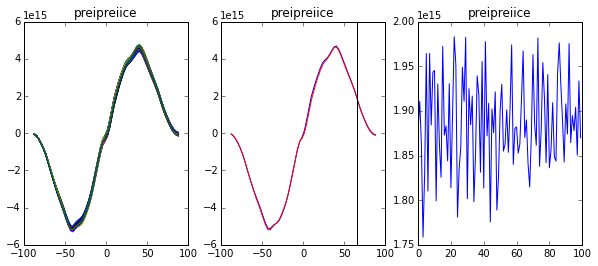

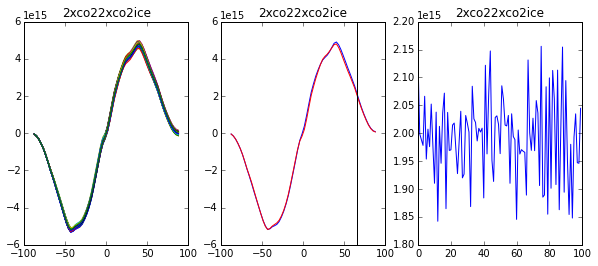

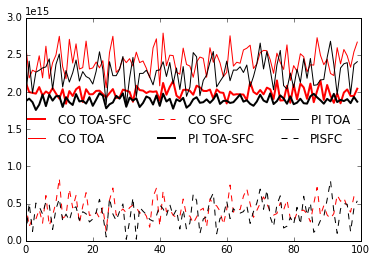

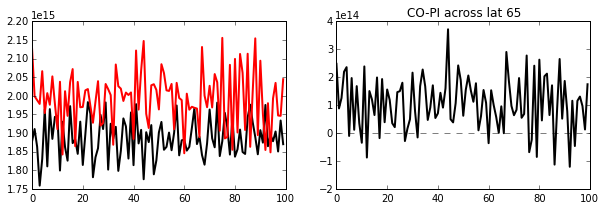

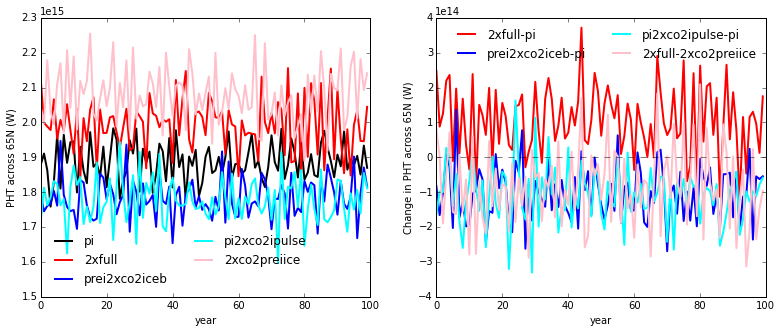

In [117]:
# plot data w/ the time dimension

acrosslat = 65
acrosslat2 = 45

if plottimeseries:
    
    latidx = cutl.find_nearest(lat,acrosslat)
    latidx2 = cutl.find_nearest(lat,acrosslat2)
    
    
    caselg=[]

    # diff of two controls
    ntime = allfluxtm['2xco22xco2ice']['nettoa'].shape[0]
    cotoa = np.cumsum(allfluxtm['2xco22xco2ice']['nettoa']*latcircles,axis=1)
    cosfc = np.cumsum(allfluxtm['2xco22xco2ice']['netsfc']*latcircles,axis=1)
    copht = cotoa-cosfc

    ntime = allfluxtm['preipreiice']['nettoa'].shape[0]
    pitoa = np.cumsum(allfluxtm['preipreiice']['nettoa']*latcircles,axis=1)
    pisfc = np.cumsum(allfluxtm['preipreiice']['netsfc']*latcircles,axis=1)
    pipht = pitoa-pisfc

    
    print copht.shape
    
    # TESTING
    fig,axs = plt.subplots(1,3, figsize=(10,4))
    ax=axs[0]
    ax.plot(lat,pipht.T)
    ax.set_title('preipreiice')
    
    ax=axs[1]
    ax.plot(lat,pipht[0,:])
    ax.plot(lat,pipht[-1,:],'r')
    ax.axvline(lat[latidx],color='k')
    ax.set_title('preipreiice')
    
    ax=axs[2]
    ax.plot(pipht[:,latidx])
    ax.set_title('preipreiice')
    
    fig,axs = plt.subplots(1,3, figsize=(10,4))
    ax=axs[0]
    ax.plot(lat,copht.T)
    ax.set_title('2xco22xco2ice')
    
    ax=axs[1]
    ax.plot(lat,copht[0,:])
    ax.plot(lat,copht[-1,:],'r')
    ax.axvline(lat[latidx],color='k')
    ax.set_title('2xco22xco2ice')
    
    ax=axs[2]
    ax.plot(copht[:,latidx])
    ax.set_title('2xco22xco2ice')
    
    # END TESTING
    
    print copht.shape
    plt.figure()
    plt.plot(copht[:,latidx],'r',linewidth=2)
    plt.plot(cotoa[:,latidx],'r')
    plt.plot(cosfc[:,latidx],'r--')
    plt.plot(pipht[:,latidx],'k',linewidth=2) 
    plt.plot(pitoa[:,latidx],'k')
    plt.plot(pisfc[:,latidx],'k--')
    plt.legend(('CO TOA-SFC','CO TOA','CO SFC',
                'PI TOA-SFC','PI TOA','PISFC'),frameon=False, 
                loc='best',ncol=3)

    fig,axs = plt.subplots(1,2,figsize=(10,3))
    ax=axs[0]
    ax.plot(pipht[:,latidx], color=colors['preipreiice'],linewidth=2)#,linestyle=linestyle)
    ax.plot(copht[:,latidx], color=colors['2xco22xco2ice'],linewidth=2)
    
    ax=axs[1]
    ax.plot(copht[:,latidx]-pipht[:,latidx],color='k',linewidth=2)
    ax.axhline(y=0,color='k',linewidth=.5,linestyle='--')
    ax.set_title('CO-PI across lat ' + str(acrosslat))
    
    
    linestyle='solid'
    
    # CLIMO
    fig,axs = plt.subplots(1,2,figsize=(13,5))
    ax=axs[0]
    ax.plot(pipht[:,latidx], color=colors['preipreiice'],linewidth=2)#,linestyle=linestyle)
    ax.plot(copht[:,latidx], color=colors['2xco22xco2ice'],linewidth=2)

    caselg.append('pi')
    caselg.append('2xfull')
    
    # pi climate
    for cii,casename in enumerate(casenames[1:3]):
        print casename
        caselg.append(casename)
        clr = colors[casename]
        thispht = calc_indir_pht(allfluxtm[casename]['nettoa'],allfluxtm[casename]['netsfc'])
        plotfld = thispht
        ax.plot(plotfld[:,latidx], color=clr,linewidth=2,linestyle=linestyle)
    # 2xco2 climate
    for cii,casename in enumerate(casenames[4:]):
        print casename
        caselg.append(casename)
        clr = colors[casename]
        thispht = calc_indir_pht(allfluxtm[casename]['nettoa'],allfluxtm[casename]['netsfc'])
        plotfld = thispht
        ax.plot(plotfld[:,latidx], color=clr,linewidth=2,linestyle=linestyle)

    ax.legend(caselg,loc='best',frameon=False,ncol=2)
    #ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('year')
    ax.set_ylabel('PHT across ' + str(acrosslat) + 'N (W)')


    # DIFFERENCES!
    print 'DIFFERENCES'
    caselg=[]
    ax=axs[1]
    ax.plot(copht[:,latidx]-pipht[:,latidx], color=colors['2xco22xco2ice'],linewidth=2)#,linestyle=linestyle)

    caselg.append('2xfull-pi')
    
    # pi climate
    for cii,casename in enumerate(casenames[1:3]):
        print casename
        caselg.append(casename+'-pi')
        clr = colors[casename]
        thispht = calc_indir_pht(allfluxtm[casename]['nettoa'],allfluxtm[casename]['netsfc'])
        plotfld = thispht-pipht
        ax.plot(plotfld[:,latidx], color=clr,linewidth=2,linestyle=linestyle)
    # 2xco2 climate
    for cii,casename in enumerate(casenames[4:]):
        print casename
        caselg.append('2xfull-'+casename)
        clr = colors[casename]
        thispht = calc_indir_pht(allfluxtm[casename]['nettoa'],allfluxtm[casename]['netsfc'])
        if thispht.shape[0]<copht.shape[0]: plotfld = -thispht+copht[:thispht.shape[0],:]
        else: plotfld = -thispht+copht
        ax.plot(plotfld[:,latidx], color=clr,linewidth=2,linestyle=linestyle)

    ax.legend(caselg,loc='best',frameon=False,ncol=2)
    ax.axhline(y=0,linestyle='--',color='k',linewidth=.5)
    ax.set_xlabel('year')
    ax.set_ylabel('Change in PHT across ' + str(acrosslat) + 'N (W)')
    #if dylim != None:
    #    ax.set_ylim(dylim)

    

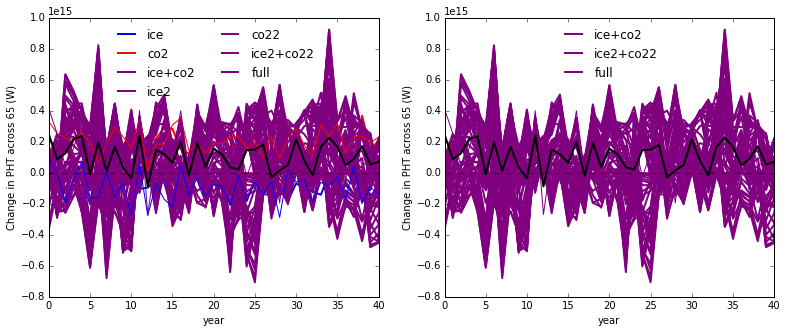

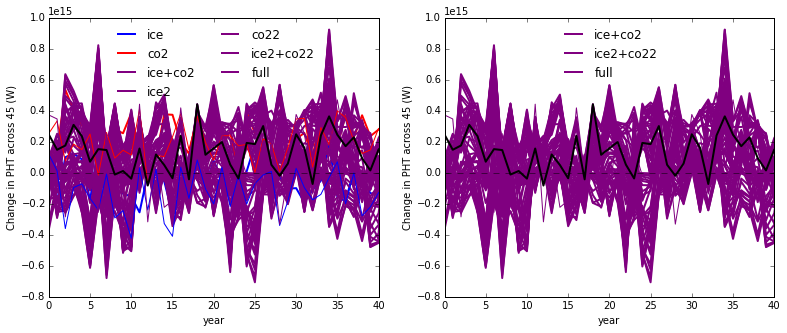

In [118]:
if plottimeseries:
    fig,axs = plt.subplots(1,2,figsize=(13,5))
    ax=axs[0]
    plot_indir_linearity_time(ax,acrosslat=acrosslat)
    ax.set_xlim(0,40)
    ax=axs[1]
    plot_indir_linearity_time(ax,acrosslat=acrosslat,justcombo=True)
    ax.set_xlim(0,40)
    
    
    acrosslat=45
    
    fig,axs = plt.subplots(1,2,figsize=(13,5))
    ax=axs[0]
    plot_indir_linearity_time(ax,acrosslat=acrosslat)
    ax.set_xlim(0,40)
    ax=axs[1]
    plot_indir_linearity_time(ax,acrosslat=acrosslat,justcombo=True)
    ax.set_xlim(0,40)
